In [182]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [183]:
# Importing data.
all_movies = pd.read_csv('../data/01_raw/all_movies.csv')

# Removing duplicates if everything but movie title is the same.
all_movies = all_movies.drop_duplicates(subset=all_movies.columns.difference(['Title', 'Error', 'Error - scraping']), keep='first')

## Splitting dataset to train and test set

In [184]:
# Checking what columns are available in dataset. And how many records there is.
all_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6921 entries, 0 to 6939
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Title                       6921 non-null   object 
 1   Written by                  4008 non-null   object 
 2   Produced by                 6893 non-null   object 
 3   Starring                    6861 non-null   object 
 4   Cinematography              6656 non-null   object 
 5   Edited by                   6851 non-null   object 
 6   Music by                    6688 non-null   object 
 7   Productioncompany           1565 non-null   object 
 8   Distributed by              6891 non-null   object 
 9   Running time                6888 non-null   object 
 10  Country                     5352 non-null   object 
 11  Language                    6315 non-null   object 
 12  Budget                      5596 non-null   object 
 13  Box office                  6921 non-n

In [185]:
# Changing 'Main release date' column to date format.
all_movies['Main release date'] = pd.to_datetime(all_movies['Main release date'])

# Years 1990-1999 won't be used in either training or testing. Those years are only used to develop new fearures based on chronology.
additional_data = all_movies.copy().loc[(all_movies['Main release date'] >= '1990-01-01') & (all_movies['Main release date'] 
                                                                                             <= '1999-12-31'), :]
train_test_data = all_movies.loc[all_movies['Main release date'] > '1999-12-31', :]

# Splitting data into train and test set.
train_data, test_data = train_test_split(train_test_data, random_state=42, test_size=0.2)

# Assigning additional column to all 3 dataframes that says from which dataset comes the data.
# It is necessary because later for part of data engineering process all dataframes will be connected back together.
# There will be some features developed that need the data to be ordered chronogically (they use past records to
# determine new values). For example: average raiting of the movies directed by specific person in the past years.
# So later this new column will be needed to split datasets again the same way they were split originally to prevent data leakage.
additional_data['Source'] = 'additional_data'
train_data['Source'] = 'train_data'
test_data['Source'] = 'test_data'

In [186]:
# Saving data.
train_data.to_csv('../data/02_in_progress/train_set.csv', index=False)
test_data.to_csv('../data/02_in_progress/test_set.csv', index=False)
additional_data.to_csv('../data/02_in_progress/additional_set.csv', index=False)

## Data cleansing

Budget and Box office

In [187]:
# Checking how values are formatted in 'Box office' and 'Budget' columns.
print(train_data['Box office'])
print(train_data['Budget'])
print(train_data.loc[train_data['Title'].str.contains('Avengers'), 'Box office'])

4208                        $52.1 million[3]
5240                                $408,709
3152    $500,000 (USA) (30 November 2000)[1]
4253                       $223.2 million[1]
6304                         $7.8 million[1]
                        ...                 
6491                           $5 million[2]
2493                        $90.7 million[1]
5143                        $38.1 million[1]
5827                       $222.4 million[1]
2891                             $124,023[2]
Name: Box office, Length: 3895, dtype: object
4208               $10 million[3]
5240                          NaN
3152    $4,000,000 (estimated)[1]
4253               $70 million[1]
6304                  $10 million
                  ...            
6491                          NaN
2493               $65 million[1]
5143               $10 million[1]
5827                $6 million[1]
2891                          NaN
Name: Budget, Length: 3895, dtype: object
4030    $2.799 billion[4]
2452    $1.519 bi

In [188]:
# I need to extract value from the column and format it taking into consideration information about million/billion.
def clean_money(df, old_column, new_column):

    df[new_column] = df[old_column].fillna('').str.lower()

    # Removing spaces between '-' and '[\d]'.
    df[new_column] = df[new_column].str.replace(r'\s?([\-\–\−\‒]{1})\s?', r'\1', regex=True)
    df[new_column] = df[new_column].str.replace(r'\[\d{1,2}\]', '', regex=True).str.strip()

    # Removing everything after last digit or words: milllion, billion.
    df[new_column] = df[new_column].str.replace(r'((?:,\d+)+(?!\s*[mb]illion)|million|billion)+[^0-9]*$', r'\1', regex=True)

    # Extracting value. If there is gross and net values then regex chooses only net. 
    def extract_value(text):
        matches = re.findall(r'(?:\$|usd)\s?\d+[.,\d\s\-\–\−\‒\$]*(?:$|million|billion|worldwide)(?!\s*\(gross\))', text)
        # If there are more than one matches to regex in the same field then I assign np.nan because I can't be sure which value
        # is correct.
        if len(matches) > 1:
            return np.nan
        elif matches:
            return matches[0]
        else:
            return np.nan

    # Removing unnecessary characters.
    df[new_column] = df[new_column].apply(extract_value)
    df[new_column] = df[new_column].str.replace('$', '')
    df[new_column] = df[new_column].str.replace('usd', '')

    # Replacing ',' with '.' when it was used incorrectly (for example 2,3 million instead of 2.3 million)
    df[new_column] = df[new_column].str.replace(r',(\d{1})\s', r'.\1', regex=True)

    # Removing '.' when it was used incorrectly.
    df[new_column] = df[new_column].str.replace(r'(\d+)\.(\d{3})(?!\s*[mb]illion)', r'\1\2', regex=True)
    
    # Removing ','.
    df[new_column] = df[new_column].str.replace(',', '').str.strip()
    
    # Splitting number from million/billion.
    values = df[new_column].str.split(r'\s', n=1, expand=True)

    # Cleaning million/billion.
    values[1] = values[1].str.replace(r'\s', '', regex=True)
    values[1] = values[1].fillna(1).replace({'million': 1e6, 'billion': 1e9})
    values[1] = pd.to_numeric(values[1])

    # Cleaning '-' when the exact sum isn't known.
    def compute_average(row):
        if not pd.isna(row[1]):
            # Minimum value has to be smaller than maximum value (in other case it is a mistake).
            if float(row[0]) < float(row[1]):
                return (float(row[0]) + float(row[1])) / 2
            else:
                return np.nan            
        else:
            return row[0]
        
    to_compute_average = values[0].str.split(r'[-\–\−\‒]', expand=True)
    values[0] = to_compute_average.apply(compute_average, axis=1)
    values[0] = pd.to_numeric(values[0], errors='coerce')

    # Assingning product to the main dataframe.
    df[new_column] = values[0] * values[1]

    # Removing values that are unrealistically high.
    df.loc[df[new_column] > 3e9, new_column] = np.nan
  
# Activating function to box office and budget.
clean_money(train_data, 'Box office', 'Clean box office')
clean_money(train_data, 'Budget', 'Clean budget')

C:\Users\jakub\AppData\Local\Temp\ipykernel_11256\4268197789.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  values[1] = values[1].fillna(1).replace({'million': 1e6, 'billion': 1e9})


Runtime

In [189]:
# Checking how values are formatted in running time columns.
print(train_data['Running time'])
print(train_data['Runtime:'])

4208        84 minutes
5240               NaN
3152        72 minutes
4253       104 minutes
6304       115 minutes
             ...      
6491    112 minutes[1]
2493       103 minutes
5143        98 minutes
5827       122 minutes
2891     89 minutes[1]
Name: Running time, Length: 3895, dtype: object
4208    1h 27m
5240    1h 26m
3152    1h 12m
4253    1h 44m
6304       NaN
         ...  
6491    1h 49m
2493    1h 43m
5143    1h 38m
5827       NaN
2891    1h 29m
Name: Runtime:, Length: 3895, dtype: object


In [190]:
# Converting times to include only number of minutes.
def clean_runtime(df):
    # Converting Running time column.
    # Sometimes there are couple of running times but this regex will always take first (that is theatrical runtime).
    df['Running time'] = df['Running time'].str.lower().str.replace(r'.*?(?<!\d)(\d{2,3}).?\d?\sm.*', r'\1', regex=True, flags=re.DOTALL)
    df['Running time'] = pd.to_numeric(df['Running time'])

    # Converting Runtime column.
    df['Runtime:'] = df['Runtime:'].str.replace(r'(?:(\d*)h\s*)?(\d{1,2})m', lambda x: str(int(x.group(1) or 0) * 60 + int(x.group(2))),
                                                regex=True)
    df['Runtime:'] = pd.to_numeric(df['Runtime:'])
    
    # If 'Running time' is empty then I fill it with 'Runtime'.
    df['Running time'] = df['Running time'].combine_first(df['Runtime:'])

clean_runtime(train_data)

Reviews and Ratings

In [191]:
# Checking how values are formatted in reviews and ratings columns.
print(train_data['Reviews_count'].head(5))
print(train_data['Ratings_count'].value_counts())

4208    136 Reviews
5240     77 Reviews
3152      2 Reviews
4253    156 Reviews
6304            NaN
Name: Reviews_count, dtype: object
Ratings_count
250,000+ Ratings                  595
50,000+ Ratings                   461
100,000+ Ratings                  446
10,000+ Ratings                   432
25,000+ Ratings                   407
5,000+ Ratings                    248
2,500+ Ratings                    201
1,000+ Ratings                    175
500+ Ratings                      112
1,000+ Verified Ratings            94
250+ Ratings                       85
100+ Ratings                       71
5,000+ Verified Ratings            52
2,500+ Verified Ratings            47
250+ Verified Ratings              42
Fewer than 50 Verified Ratings     41
10,000+ Verified Ratings           40
500+ Verified Ratings              40
100+ Verified Ratings              32
50+ Verified Ratings               22
50+ Ratings                        21
Fewer than 50 Ratings              19
25,000+ Verifie

In [192]:
# Converting to numeric values.
def clean_reviews_ratings(df):
    # Converting 'Reviews_count' column.
    df['Reviews_count'] = df['Reviews_count'].str.lower().str.replace(r'(\d+).*', r'\1', regex=True)
    df['Reviews_count'] = pd.to_numeric(df['Reviews_count'])

    # Converting 'Ratings_count' column.
    # I decided to change 'Fewer than 50...' to 25 and the rest to numbers that it says in strings.
    df['Ratings_count'] = df['Ratings_count'].str.replace(',', '')
    df['Ratings_count'] = df['Ratings_count'].str.replace('Fewer than 50', '25')
    df['Ratings_count'] = df['Ratings_count'].str.replace(r'(\d+).*', r'\1', regex=True)
    df['Ratings_count'] = pd.to_numeric(df['Ratings_count'])

clean_reviews_ratings(train_data)

Age rating

In [193]:
# Checking how values are formatted in 'Rating' (age limitation) column.
train_data['Rating:']

4208                                              PG (Action and Rude Humor)
5240                            R (Sexual References|Language|Some Drug Use)
3152                                                                       G
4253                        PG-13 (Crude Sexual Humor|Brief Nudity|Language)
6304                                                                     NaN
                                        ...                                 
6491    R (Graphic Nudity|Brief Sexuality|Language|Some Disturbing Violence)
2493                                             PG-13 (Sensuality|Language)
5143                               R (Sexual Content|Language|Some Drug Use)
5827                                                                     NaN
2891                                                                     NaN
Name: Rating:, Length: 3895, dtype: object

In [194]:
# Leaving only age category.
def clean_age_rating(df):
    df['Rating:'] = df['Rating:'].str.split(' ').str[0]
    # 'NC-17' is so rare that I decided to put it to the closest similar age category 'R'.
    df['Rating:'] = df['Rating:'].str.replace('NC-17', 'R')
    # Filling in rows that don't have correct cinema rating with NaN value (for example there could be couple instances of TV rating).
    df.loc[~df['Rating:'].isin(['G', 'PG', 'PG-13', 'R']), 'Rating:'] = np.nan

clean_age_rating(train_data)
train_data['Rating:'].value_counts()

Rating:
R        1656
PG-13    1333
PG        474
G          70
Name: count, dtype: int64

Genres

In [195]:
# Checking how values are formatted in 'Genre' column.
pd.set_option('display.max_colwidth', 160)
train_data['Genre:']

4208    Kids & family, \n                            \n                            Comedy, \n                            \n                            Adventure, \n...
5240                                                                                                                                                             Comedy
3152                                                                                   Kids & family, \n                            \n                            Drama
4253                                                                                                                                                             Comedy
6304                                                                                                                                                                NaN
                                                                                     ...                                                                        

In [196]:
# Cleaning and splitting genres to different columns.
def split_genres(df):
    # I'm taking only 3 main genres because after that there are mostly missing values.
    splitted = df['Genre:'].str.split(',', n=3, expand=True)
    splitted = splitted.iloc[:, :3].apply(lambda x: x.str.strip())
    splitted.columns = ['Genre_' + str(col + 1) for col in splitted.columns]
    df = pd.concat([df, splitted], axis=1)
    return df
                  
train_data = split_genres(train_data)

Actors

In [197]:
# Checking how column with actors is formated.
train_data['Starring']

4208    \nGreg Cipes\nScott Menville\nKhary Payton\nTara Strong\nHynden Walch\nWill Arnett\nKristen Bell\n
5240        \nSeann William Scott\nJohn C. Reilly\nJenna Fischer\nLili Taylor\nFred Armisen\nGil Bellows\n
3152             \nAngela Bassett\nJoanna Lumley\nAnne Archer\nDebi Derryberry\nKevin Michael Richardson\n
4253                  \nJim Carrey\nZooey Deschanel\nBradley Cooper\nJohn Michael Higgins\nTerence Stamp\n
6304                         \nKuno Becker\nAlessandro Nivola\nAnna Friel\nStephen Dillane\nRutger Hauer\n
                                                       ...                                                
6491                                          \nOscar Isaac\nTiffany Haddish\nTye Sheridan\nWillem Dafoe\n
2493    \nRichard Gere\nWinona Ryder\nAnthony LaPaglia\nElaine Stritch\nVera Farmiga\nSherry Stringfield\n
5143                       \nGoldie Hawn\nSusan Sarandon\nGeoffrey Rush\nErika Christensen\nRobin Thomas\n
5827                                 

In [198]:
def split_actors(df):
    patterns_to_replace = {
        r'\[.*\]': '',
        r'\(.*\)': '',
        ', Jr.': ' Jr.',
        '\n': ',',
        # In some cases actors aren't split at all. I recognize these cases by finding small and large letters next to each other.
        # I'm making sure not to split names like 'McAdams' by adding condition that there can't be large-small-large combination.
        r'[^A-Z]([a-z\.ąćęłńóśźżäöüñéáò])([A-Z])': r'\1, \2'
    }

    df['Starring'] = df['Starring'].str.strip()

    # Adding ', ' between actors.
    for pattern, replacement in patterns_to_replace.items():
        df['Starring'] = df['Starring'].str.replace(pattern, replacement, regex=True)

    # Splitting actors to different columns.
    # I'm saving only 5 actors - looking through some of the casts and some testing I decided that this will be optimal value
    # to include actors with meaningful roles that can have 'star effect' on the movie's performance.
    splitted = df['Starring'].str.split(',', n=5, expand=True)
    splitted = splitted.iloc[:, :5].apply(lambda x: x.str.strip())
    splitted.columns = ['Actor_' + str(col + 1) for col in splitted.columns]
    df = pd.concat([df, splitted], axis=1)
    return df

train_data = split_actors(train_data)

Based on

In [199]:
# Splitting movies between movies based on other media and based on original idea.
def map_based_on(df, print_=False):
    df.loc[df['Based on'].notnull(), 'Based on'] = 1
    df.loc[df['Based on'].isnull(), 'Based on'] = 0
    if print_:
        print(df['Based on'].value_counts())

map_based_on(train_data, True)

Based on
0    2244
1    1651
Name: count, dtype: int64


Language

In [200]:
# Splitting movies between English movies and foreign language movies.
def clean_language(df, print_=False):
    # If 'Original Language' column is empty then I fill it with 'Language' column.
    df['Original Language:'] = df['Original Language:'].combine_first(df['Language'])
    # Changing to 0-1.
    df['English'] = 0
    df.fillna({'Original Language:': ''}, inplace=True)
    df.loc[df['Original Language:'].str.startswith('English'), 'English'] = 1
    if print_:
        print(df['English'].value_counts())

clean_language(train_data, True)

English
1    3753
0     142
Name: count, dtype: int64


Distributors

In [201]:
# Cleaning distributors.

def clean_distributors(df, print_=False):
    # Connecting 2 columns together and some cleaning.
    df['Distributed by'] = df['Distributed by'].combine_first(df['Distributor:'])
    df['Distributed by'] = df['Distributed by'].str.replace(r'\[.*\]', '', regex=True)
    df['Distributed by'] = df['Distributed by'].str.replace(r'([a-z])([A-Z])', r'\1 \2', regex=True)
    df['Distributed by'] = df['Distributed by'].str.replace('\n', '').str.strip()

    # Both Buena Vista Pictures Distribution and Walt Disney Studios Motion Pictures are part of Walt Disney Studios.
    # '20th Century Studios' is the new name of '20th Century Fox' after it was bought by Disney.
    df['Distributed by'] = df['Distributed by'].str.replace(r'(Walt Disney|Buena Vista|20th Century Studios).*',
                                                            'Walt Disney Studios', regex=True)
    # Time Warner took over New Line Cinema in 1996.
    df.loc[df['Main release date'] > '1996-12-31', 'Distributed by'] = df.loc[df['Main release date'] > '1996-12-31',
                                                                    'Distributed by'].str.replace(r'New Line Cinema.*',
                                                                                                  'Warner Bros. Pictures', regex=True)
    df['Distributed by'] = df['Distributed by'].str.replace(r'Warner.*', 'Warner Bros. Pictures', regex=True)
    df['Distributed by'] = df['Distributed by'].str.replace(r'Universal.*', 'Universal Pictures', regex=True)
    df['Distributed by'] = df['Distributed by'].str.replace(r'Paramount.*', 'Paramount Pictures', regex=True)
    df['Distributed by'] = df['Distributed by'].str.replace(r'Sony Pictures.*', 'Sony Pictures Releasing', regex=True)
    df['Distributed by'] = df['Distributed by'].str.replace(r'20th Century Fox.*', '20th Century Fox', regex=True)
    df['Distributed by'] = df['Distributed by'].str.replace(r'Lionsgate.*', 'Lionsgate', regex=True)
    # I qualify streaming platforms as different category despite having small number of movies because they are distributed to small
    # number of theaters just to meet the conditions of being considered in big movie awards and most people watch them on streaming.
    df['Distributed by'] = df['Distributed by'].str.replace(r'(Netflix|HBO|Apple).*', 'Streaming', regex=True)

    # I decided to separate 8 studios and clasify the rest as 'Other studio'. I also remove movies with missing value in this field
    # because there are only couple of them and all of them are missing 'Clean budget' which seems to be key feature.
    df.dropna(subset=['Distributed by'], inplace=True)
    biggest_studios = ['Warner Bros. Pictures', 'Sony Pictures Releasing', 'Universal Pictures', 'Walt Disney Studios', '20th Century Fox',
                       'Paramount Pictures', 'Lionsgate', 'Streaming']
    df.loc[~df['Distributed by'].isin(biggest_studios), 'Distributed by'] = 'Other studio'

    if print_:
        print(df['Distributed by'].value_counts())

clean_distributors(train_data, True)

Distributed by
Other studio               1747
Warner Bros. Pictures       456
Sony Pictures Releasing     379
Universal Pictures          310
Walt Disney Studios         252
Paramount Pictures          251
20th Century Fox            244
Lionsgate                   216
Streaming                    36
Name: count, dtype: int64


Director_2

In [202]:
# Checking if 'Director_2' column is at all useful.

# Checking if any of directors in 'Director_2' appears in 'Director_1'
director_2 = list(train_data['Director_2'].unique())
print(f'Number of appearence as Director_1: {len(train_data.loc[train_data["Director_1"].isin(director_2), :])}')

# Checking how many of Director_2 are unique values.
print(f'{len(train_data["Director_2"].unique())} out of {len(train_data.loc[train_data["Director_2"].notnull(), :])} is unique.')

Number of appearence as Director_1: 0
187 out of 242 is unique.


In [203]:
# Considering above information there is no point in using Director_2 field.

Removing columns

In [204]:
# Removing unnecesary records and columns.
def remove_rows_cols(df):
    # Leaving only useful columns.:
    necessary_columns = ['Title', 'Distributed by', 'Running time', 'Based on', 'Main release date', 'Director_1',
                         'Rating:', 'Reviews_score', 'Ratings_score', 'Reviews_count', 'Ratings_count', 'Synopsis',
                         'Clean box office', 'Clean budget', 'Genre_1', 'Genre_2', 'Genre_3', 'Actor_1', 'Actor_2',
                         'Actor_3', 'Actor_4', 'Actor_5', 'English', 'Description', 'Source']
    df = df[necessary_columns]

    # Removing records if box office is empty - it's the target of ML so this column can't be left when it's null. 
    df = df.dropna(subset=['Clean box office'])
    return df

train_data = remove_rows_cols(train_data)

## Data exploration and filling in missing values

In [205]:
# Of course to see the full picture in exploratory analysis I would need to use the whole dataset but because
# the main subject of this project is creating machine learning model I can't use test dataset on this stage because
# it would lead to data leakage and bad generalization by model.

In [206]:
# Checking general statistics.
train_data.describe()

,Running time,Main release date,Reviews_score,Ratings_score,Reviews_count,Ratings_count,Clean box office,Clean budget,English
count,3855.000000,3858,3649.000000,3666.000000,3666.000000,3666.000000,3.858000e+03,3.136000e+03,3858.000000
mean,106.988846,2011-09-20 00:02:14.370139904,53.966840,61.010366,149.235406,63802.768685,1.046450e+08,4.565717e+07,0.966822
min,38.000000,2000-01-12 00:00:00,0.000000,7.000000,1.000000,25.000000,6.180000e+02,3.000000e+04,0.000000
25%,94.000000,2006-07-20 06:00:00,30.000000,46.000000,85.000000,2500.000000,4.500000e+06,1.200000e+07,1.000000
50%,104.000000,2011-03-11 00:00:00,55.000000,62.000000,136.000000,25000.000000,3.110000e+07,2.650000e+07,1.000000
75%,116.000000,2017-06-15 12:00:00,79.000000,77.000000,196.000000,100000.000000,1.096000e+08,6.000000e+07,1.000000
max,246.000000,2023-12-19 00:00:00,100.000000,100.000000,601.000000,250000.000000,2.923000e+09,4.470000e+08,1.000000
std,17.804308,NaN,27.457139,19.774331,91.944796,87693.097931,2.037711e+08,5.248943e+07,0.179124


Target: 'Box Office';  
Feature: 'Year'

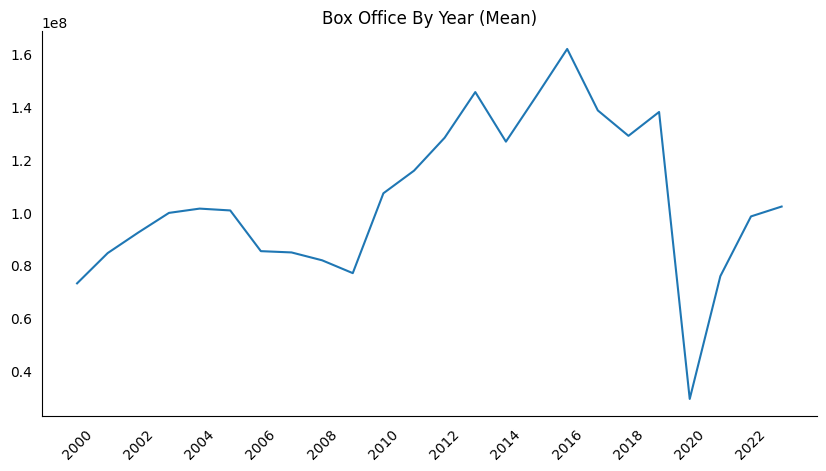

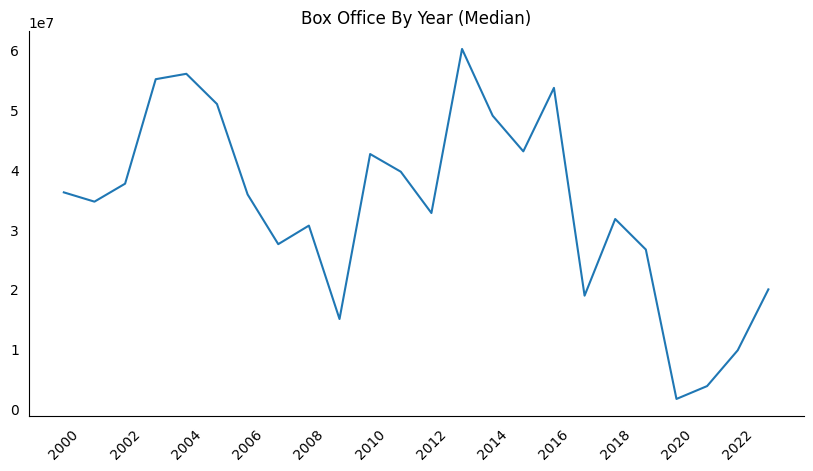

In [207]:
# Additional column for easier grouping by year.
train_data['Year'] = train_data['Main release date'].dt.year

# First, let's take a look at our target and check how time affects box office results.
def simple_line_chart(df, column_name, title_part, aggregate_func, *ylims):
    if aggregate_func == 'mean':
        grouped_data = df.groupby(df['Year'])[column_name].mean()
    elif aggregate_func == 'median':
        grouped_data = df.groupby(df['Year'])[column_name].median()
    plt.figure(figsize=(10, 5))
    plt.plot(grouped_data.index, grouped_data.values, linestyle='-')
    plt.title(f'{title_part} By Year ({aggregate_func.capitalize()})')
    plt.xticks(np.arange(min(grouped_data.index), max(grouped_data.index), 2), rotation=45)
    plt.tick_params(bottom=False, left=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if ylims:
        plt.ylim(*ylims)
    plt.show()

simple_line_chart(train_data, 'Clean box office', 'Box Office', 'mean')
simple_line_chart(train_data, 'Clean box office', 'Box Office', 'median')

New feature: 'Covid-19'

In [208]:
# We can see that time has a great impact on movie industry.
# The rise around year 2009 in mean can be explained by rising popularity of super hero films.
# Exactly in year 2009 Walt Disney bought Marvel Entertainment and soon started flooding the market with high budget
# Marvel blockbusters (with the first film distribuuted by them in 2012), soon after they also bought Lucasfilm Ltd.
# and started producing high budget Star Wars films.

# On the other hand the great fall in 2020 can be explained by shutting down cinemas because of pandemic of Covid-19.
# This factor has to be deifinitely added as feature because even if cinemas were open at the time there were limits
# in seats or movies had simultaneous premieres in streaming servises which also decreased revenue.
# I decided to add this feature between 1 March 2020 (closing theaters in US) and 11 May 2021 (official end of the pandemic).
def add_pandemic(df, print_=False):
    df['Covid-19'] = 0
    df.loc[(df['Main release date'] >= '2020-03-01') & (df['Main release date'] <= '2021-05-11'), 'Covid-19'] = 1
    if print_:
        print(df['Covid-19'].value_counts())

add_pandemic(train_data, True)

Covid-19
0    3729
1     129
Name: count, dtype: int64


Target: 'Box Office'

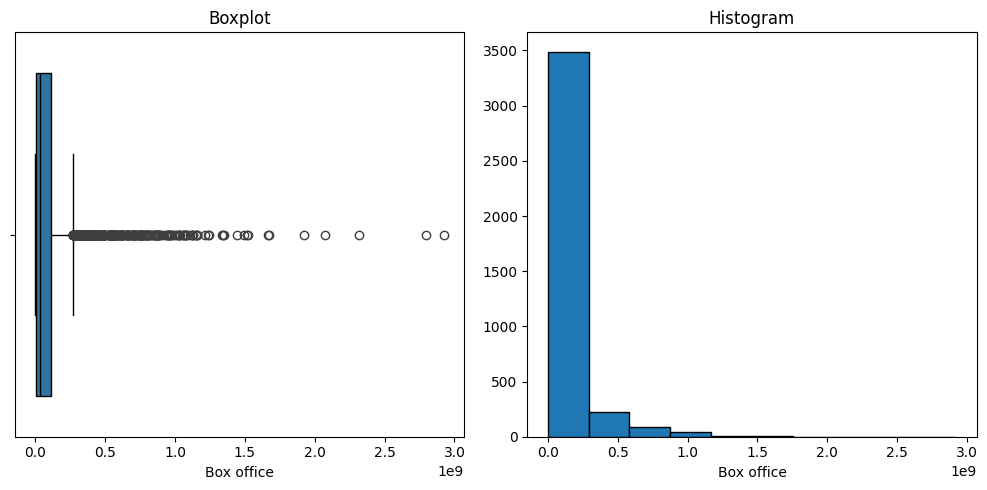

In [209]:
# Function to create boxplot and histogram to see data distribution.
def boxplot_and_hist(df, column_name, x_name):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Creating boxplot.
    sns.boxplot(x=df[column_name], ax=axes[0], boxprops=dict(edgecolor='black'), whiskerprops=dict(color='black'),
                            medianprops=dict(color='black'), capprops=dict(color='black'))
    axes[0].set_title(f'Boxplot')
    axes[0].set_xlabel(x_name)
    
    # Creating histogram.
    df[column_name].hist(grid=False, ax=axes[1], edgecolor='black')
    axes[1].set_title(f'Histogram')
    axes[1].set_xlabel(x_name)
    plt.tight_layout()

boxplot_and_hist(train_data, 'Clean box office', 'Box office')

# We can see that lower end values are far more probable.

Feature: 'Distributed by'

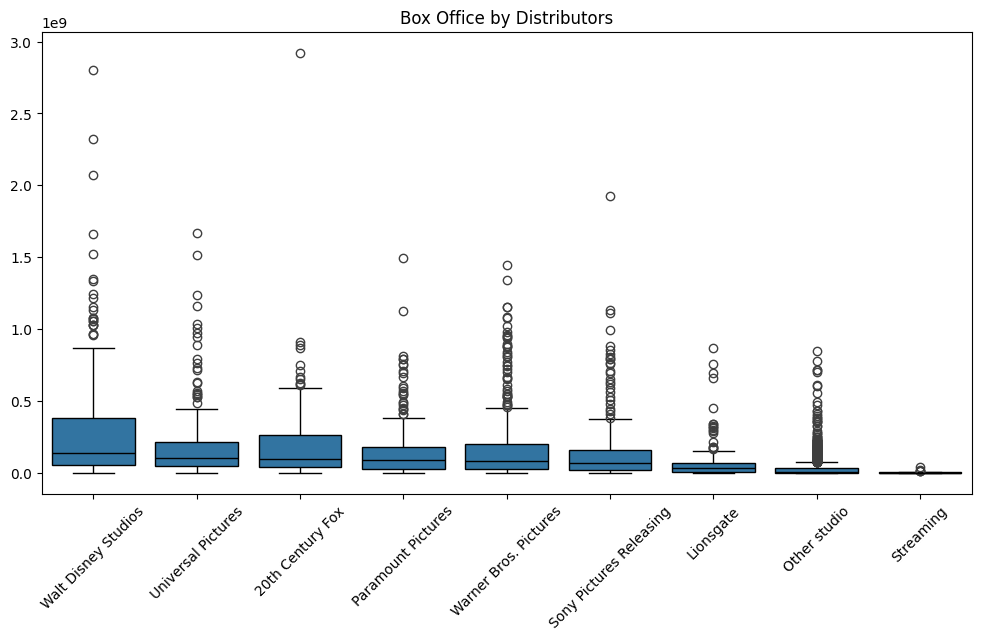

In [210]:
# Let's also see box office by particular studios to check whether they have impact on our target.

# Function to vizualize boxplots by studio.
def boxplot_by_studio(df, column_name, y_title):
    # Sorting by median.
    medians = df.groupby('Distributed by')[column_name].median()
    sorted_categories = medians.sort_values(ascending=False).index

    # Boxplots fo every group.
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Distributed by', y=column_name, data=df, order=sorted_categories, boxprops=dict(edgecolor='black'),
                whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'))
    plt.title(f'{y_title} by Distributors')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45)
    plt.show()

boxplot_by_studio(train_data, 'Clean box office', 'Box Office')

# We can see that distributors have an impact on box office results. Especially Lionsgate and Other studios get much lower results.

Features: 'Distributed by' and 'Year'

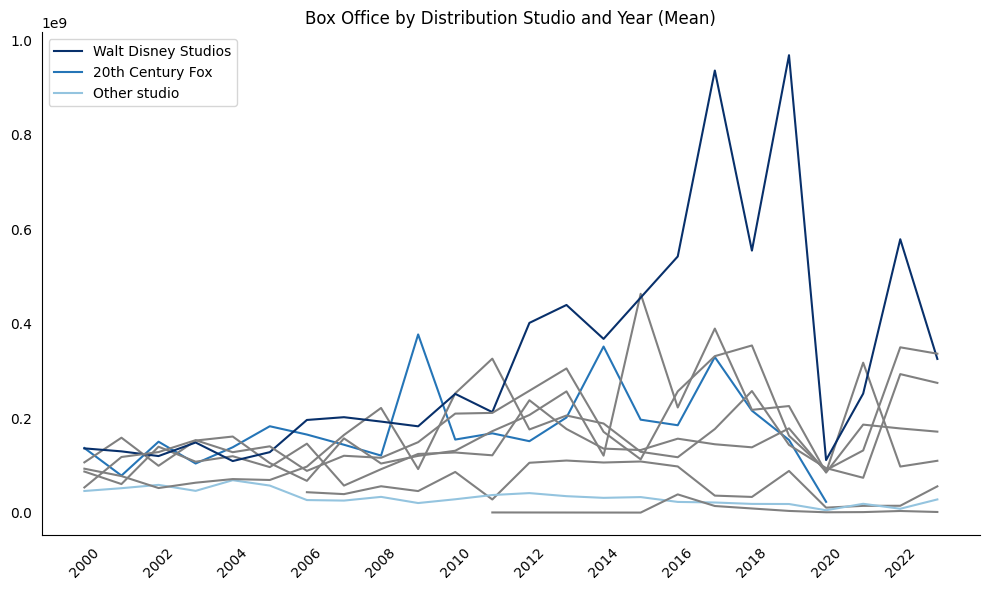

In [211]:
# Let's also see the impact of year and studio at the same time.

# Creating line charts for every distribution studio.
def create_line_charts(df, column_name, aggregate_func, title):

    # Choosing color palette for lines.
    cmap = plt.get_cmap('Blues')

    # Grouping by 'Distributed by'.
    if aggregate_func == 'mean':
        grouped_data = df.groupby(['Distributed by', 'Year'])[column_name].mean().reset_index()
    elif aggregate_func == 'median':
        grouped_data = df.groupby(['Distributed by', 'Year'])[column_name].median().reset_index()

    # Adding lines to the chart.
    fig, ax = plt.subplots(figsize=(10, 6))
    for category, data in grouped_data.groupby('Distributed by'):
        if category == 'Walt Disney Studios':
            ax.plot(data['Year'], data[column_name], linestyle='-', color=cmap(3/3), label=category)
        elif category == '20th Century Fox':
            ax.plot(data['Year'], data[column_name], linestyle='-', color=cmap(2.2/3), label=category)
        elif category == 'Other studio':
            ax.plot(data['Year'], data[column_name], linestyle='-', color=cmap(1.2/3), label=category)
        else:
            ax.plot(data['Year'], data[column_name], linestyle='-', color='gray')

    ax.set_title(f'{title} by Distribution Studio and Year ({aggregate_func.capitalize()})')
    ax.set_xticks(np.arange(min(df['Year']), max(df['Year']), 2))
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(bottom=False, left=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Setting legend labels in the chosen order.
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,0,1]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

    plt.tight_layout()
    plt.show()

create_line_charts(train_data, 'Clean box office', 'mean', 'Box Office')

# I highlighted Walt Disney Studio because it has biggest variations.
# I also highlited 20th Century Fox because its line ends on 2020. It's due to the fact that studio was bought by Disney.

In [212]:
# Let's also take a look at the summary of descriptive statistics by studios.
train_data.groupby('Distributed by')['Clean box office'].describe().sort_values(by='50%', ascending=False)

# As seen in high differences in distribution between some studios 'Distributed by' column can be potentially
# valuable feature with considerable explanatory power.

,count,mean,std,min,25%,50%,75%,max
Distributed by,,,,,,,,
Walt Disney Studios,249.0,3.018705e+08,4.062591e+08,84918.000,49900000.00,137300000.0,379800000.0,2.799000e+09
Universal Pictures,309.0,1.761099e+08,2.289760e+08,6975.000,43100000.00,98300000.0,216000000.0,1.671000e+09
20th Century Fox,244.0,1.854618e+08,2.569797e+08,352810.000,36175000.00,94450000.0,263925000.0,2.923000e+09
Paramount Pictures,251.0,1.491191e+08,1.997030e+08,64389.000,28350000.00,84700000.0,175500000.0,1.496000e+09
Warner Bros. Pictures,454.0,1.669345e+08,2.327655e+08,27909.000,28050000.00,83250000.0,199450000.0,1.446000e+09
Sony Pictures Releasing,375.0,1.301235e+08,2.031548e+08,70958.000,15350000.00,67900000.0,159950000.0,1.922000e+09
Lionsgate,216.0,6.418604e+07,1.184387e+08,25396.000,4950000.00,31650000.0,67225000.0,8.650000e+08
Other studio,1724.0,3.067984e+07,7.041725e+07,618.000,797795.50,7000000.0,29700000.0,8.486000e+08
Streaming,36.0,3.173666e+06,7.115987e+06,7502.846,128032.25,701152.0,2225000.0,3.860000e+07


In [213]:
# Dummy encoding of distributors.
def dummy_encoding(df, column_name):
    dummy_df = pd.get_dummies(df[column_name])
    df = pd.concat([df, dummy_df], axis=1)
    return df

train_data = dummy_encoding(train_data, 'Distributed by')

Feature: 'Month'

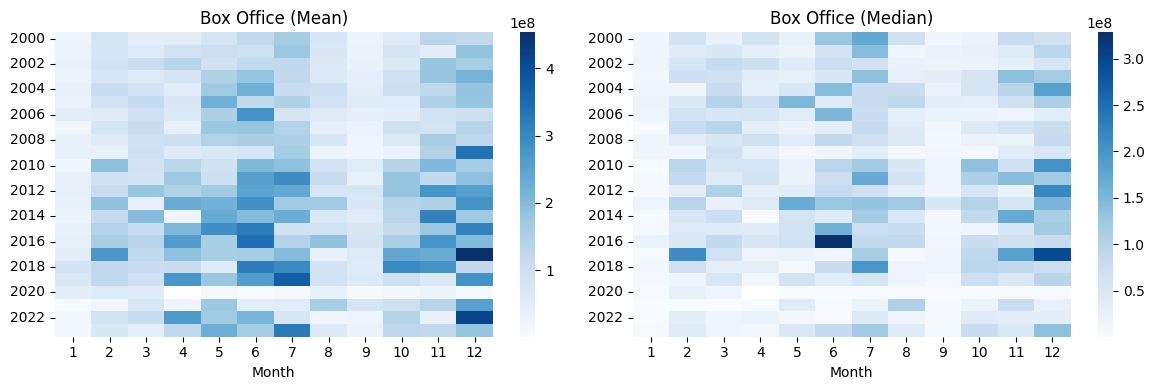

In [214]:
# Let's also see what is the impact of the month on movie's box office.
# This impact is possible because of something called 'blockbuster season'.

# Creating additional column with month.
train_data['Month'] = train_data['Main release date'].dt.month

# Function to create heatmap by month using mean and median.
def month_hetmap(df, column_name, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    aggfuncs = ['mean', 'median']
    titles = [f'{title} (Mean)', f'{title} (Median)']
    for i in range(2):
        pivot_table = df.pivot_table(index='Year', columns='Month', values=column_name, aggfunc=aggfuncs[i])
        sns.heatmap(pivot_table, cmap='Blues', ax=axs[i])
        axs[i].set_title(titles[i])
        axs[i].set_ylabel('')
    plt.tight_layout()
    plt.show()

month_hetmap(train_data, 'Clean box office', 'Box Office')

# We observe a notable increase in box office revenue during late spring and early summer, as well as towards the end of the year.
# This suggests that the month indeed influences box office performance. However, its impact is not linear, making it unsuitable as
# a feature for linear regression. Nonetheless, it holds potential to yield improved results when utilized within more complex models.

Feature: 'Budget'

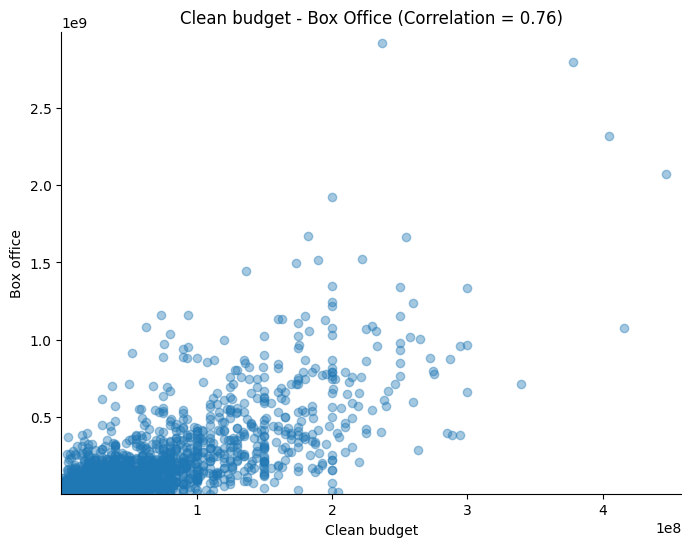

In [215]:
# Budget is probably the best predictor of box office. Let's start by checking their correlation on scatter plot.
def plot_corr(df, column_name):
    df = df.loc[df[column_name].notnull(), :]
    x = df[column_name]
    y = df['Clean box office']
    correlation = np.corrcoef(x, y)[0, 1]
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='tab:blue', alpha=0.4)
    plt.title(f'{column_name} - Box Office (Correlation = {round(correlation, 2)})')
    plt.xlabel(column_name)
    plt.ylabel('Box office')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # Setting margins only at the top and on the right side.
    plt.margins(x=0, y=0)
    plt.xlim(right=x.max() + (x.max() - x.min()) * 0.025)
    plt.ylim(top=y.max() + (y.max() - y.min()) * 0.025)
    plt.show()

plot_corr(train_data, 'Clean budget')

# As assumed scatter plot shows high correlation between budget and box office.

In [216]:
# To use this feature I need to decide what to do with missing values.

# Checking how many missing values there is in budget.
def ratio_of_na(df, column_name):
    missing_values = sum(df[column_name].isna())
    all_values = len(df[column_name])
    print(f'Ratio of missing values: {round(missing_values / all_values, 4)}')

ratio_of_na(train_data, 'Clean budget')

# There's almost 19% of missing values, too much to drop them.

Ratio of missing values: 0.1871


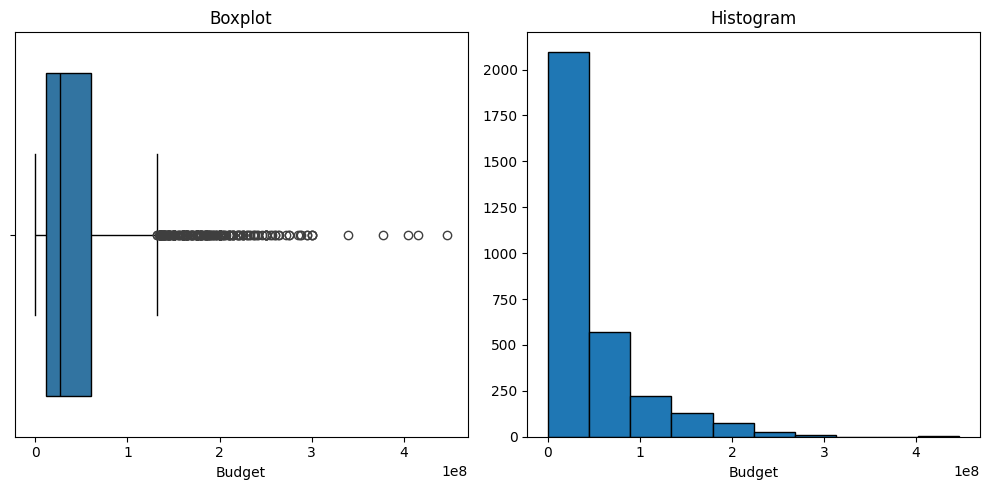

In [217]:
# Checking boxplot and histogram to decide whether to use median or mean to fill in missing values.
boxplot_and_hist(train_data, 'Clean budget', 'Budget')

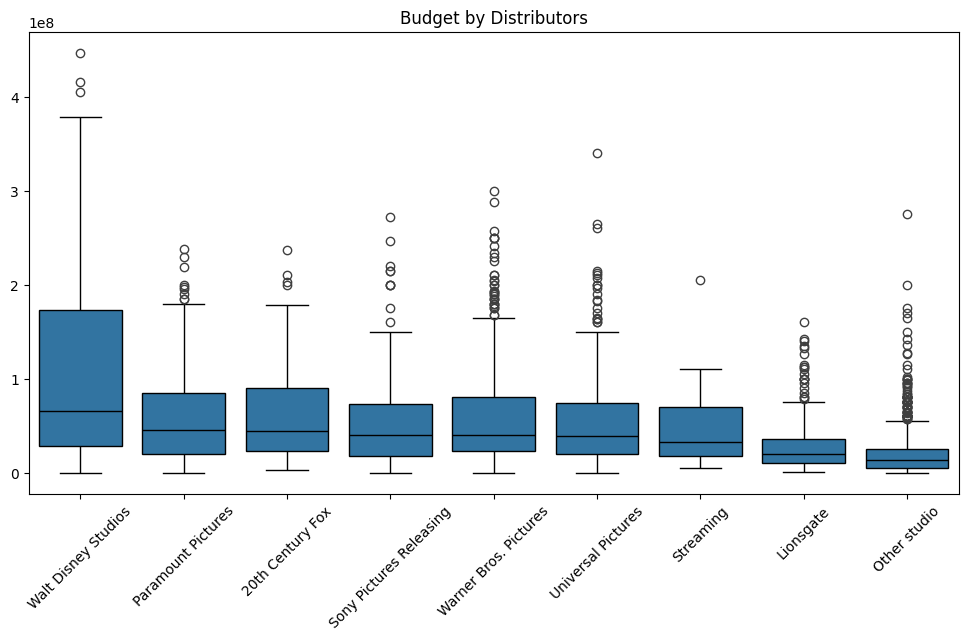

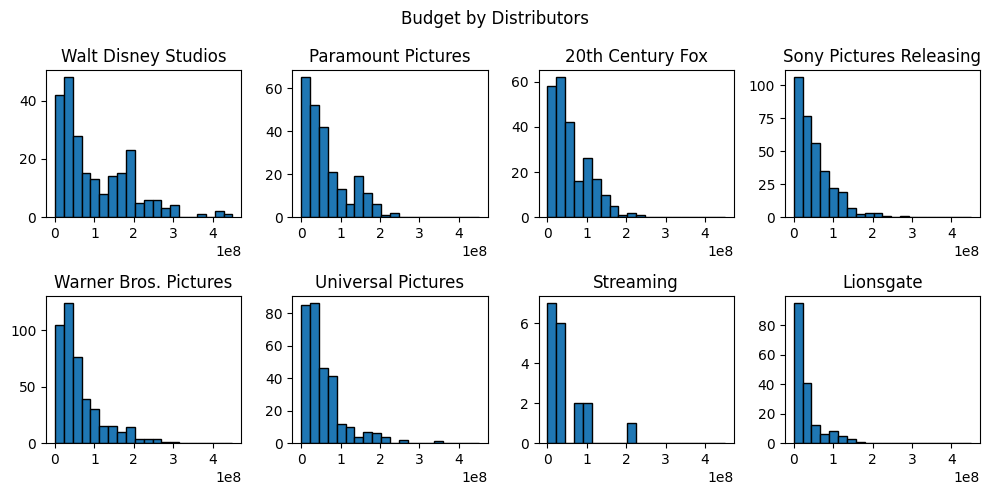

In [218]:
# The budget doesn't follow normal distribution, it's concentrated on the lower end and the mean is much higher than median.
# I'm going to use the median but let's see how it looks when grouped by studios.

# Funtion to create histograms with grouping.
def histogram_by_studio(df, column_name, y_title):
    # Sorting by median.
    medians = df.groupby('Distributed by')[column_name].median()
    sorted_categories = medians.sort_values(ascending=False).index

    # Histograms for every group.
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for row in range(2):
        for col in range(4):
            # Selecting appropriate axis in the grid
            ax = axes[row, col]
            # Choosing group.
            i = row * 4 + col
            category = sorted_categories[i]
            # Creating histogram for the given group.
            category_data = df[df['Distributed by'] == category][column_name]
            category_data = category_data.dropna()
            bin_width = np.diff(np.histogram_bin_edges(category_data, bins=20))[0]
            ax.hist(category_data, bins=20, range=(0, 4.5e8), edgecolor='black')
            ax.set_title(f'{category}')
            ax.set_xlabel('')
            ax.set_ylabel('')
            # Set the ticks on x-axis with a step of 1e8
            ax.set_xticks(np.arange(0, 4.5e8 + bin_width, 1e8))

    plt.suptitle(f'{y_title} by Distributors')
    plt.tight_layout()
    plt.show()

boxplot_by_studio(train_data, 'Clean budget', 'Budget')
histogram_by_studio(train_data, 'Clean budget', 'Budget')

# We can see that datasets for every group is very different: especially Disney and Other studio categories.
# This is why I will include grouping while filling in missing values in 'Clean budget' with medians.

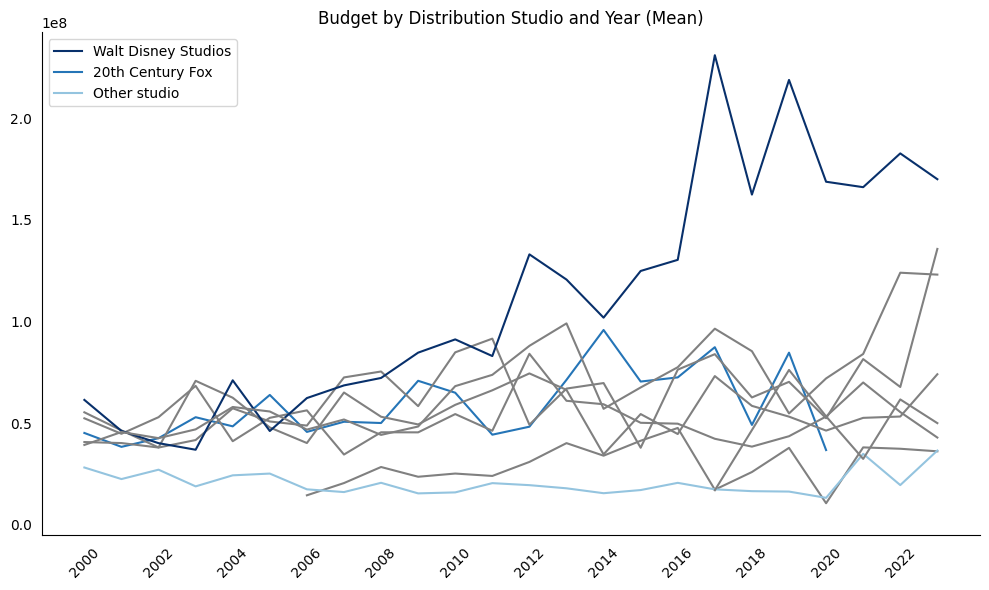

In [219]:
# Let's see budget for studios by year.

create_line_charts(train_data, 'Clean budget', 'mean', 'Budget')

# I highlighted Walt Disney Studio cause it has biggest variations. Also we can see growth in average budget during last decade.
# Like I mentioned before it's due to acquisition of Marvel Entertainment and Lucasfilm Ltd.
# I also highlited 20th Century Fox because its line ends on 2020. It's due to the fact that studio was also bought by Disney.

In [220]:
# Before filling in missig values let's also see how many of them is missing in every studio.
train_data.loc[train_data['Clean budget'].isna(), 'Distributed by'].value_counts()

# By far most of the missing values are in 'Other studio'. This makes sense because those are smaller movies.
# Because, as seen on the line chart above, 'Other studio' line is the most steady one so I won't consider
# year while filling in missing values.

Distributed by
Other studio               567
Lionsgate                   45
Sony Pictures Releasing     43
Streaming                   18
Walt Disney Studios         15
Paramount Pictures          13
Warner Bros. Pictures       12
Universal Pictures           5
20th Century Fox             4
Name: count, dtype: int64

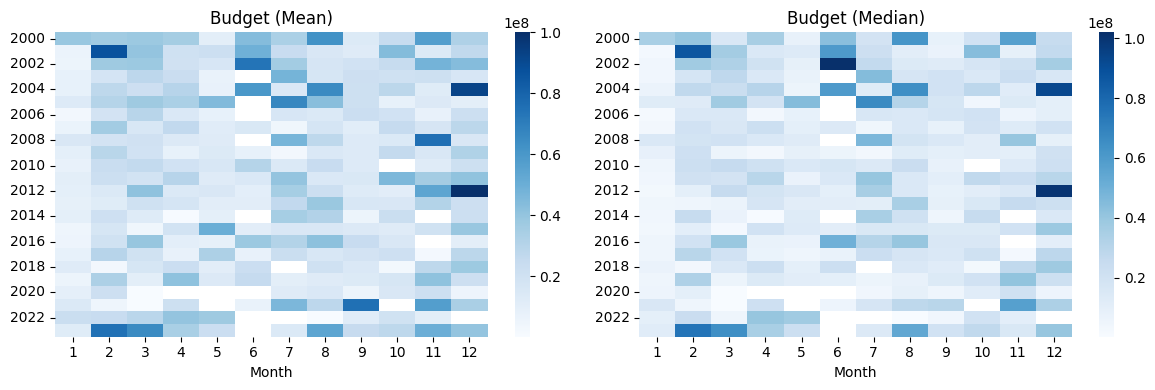

In [221]:
# Let's also see what is the impact of the month on production budget of 'Other studio' movies.
train_data_other_stdio = train_data.loc[train_data['Distributed by'] == 'Other studio', :]
month_hetmap(train_data_other_stdio, 'Clean budget', 'Budget')

# When it comes to 'Other studio' movies month doesn't seem to have an impact so I don't need to include it
# when filling in missing values.

In [222]:
# Function to fill in missing values.
def fill_with_median(df, column_to_fill, column_to_group=False):
    if column_to_group:
        medians = df.groupby(column_to_group)[column_to_fill].transform('median')
    else:
        medians = df[column_to_fill].median()

    df[column_to_fill] = df[column_to_fill].fillna(medians)

# Filling in missing values in budget using median and grouping by studios.
fill_with_median(train_data, 'Clean budget', 'Distributed by')

Feature: 'Runnig time'

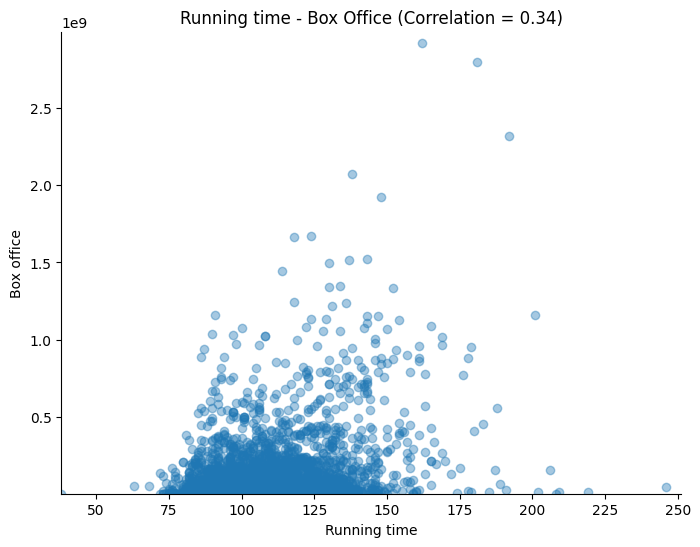

In [223]:
# Checking correlation of runtime with box office.
plot_corr(train_data, 'Running time')

In [224]:
# Checking ratio of missing values in runtime.
ratio_of_na(train_data, 'Running time')

Ratio of missing values: 0.0008


In [225]:
# Filling in missing values using median (without any grouping). Because the ratio of missing values is so small
# I refrain from further analysis and groupings.
fill_with_median(train_data, 'Running time')

Features: 'Ratings' score' and 'Reviews' score'

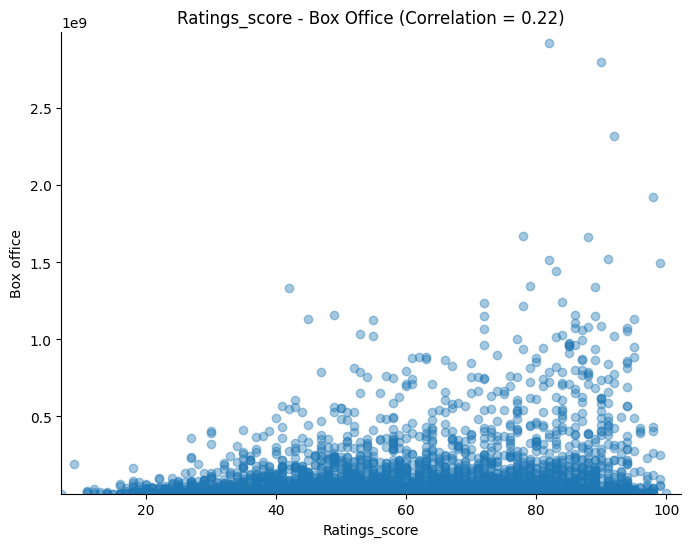

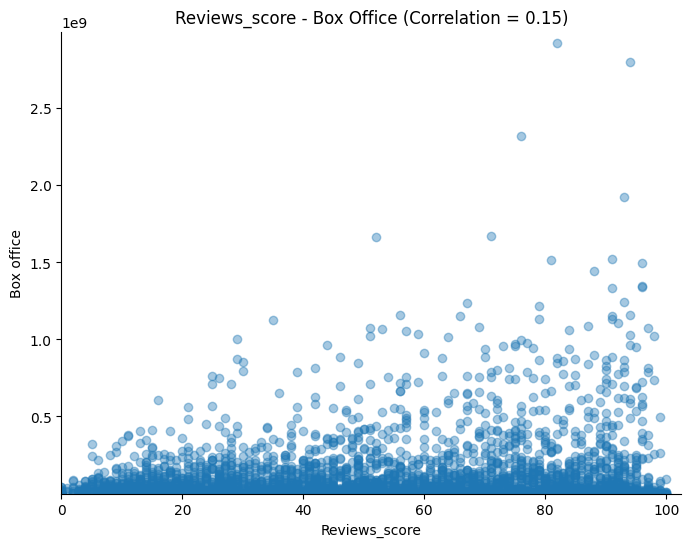

In [226]:
# Checking correlations with box office.

# Ratings.
plot_corr(train_data, 'Ratings_score')

# Reviews.
plot_corr(train_data, 'Reviews_score')

# There doesn't appear to be visible correlation but let's remember that these scores aren't the final features
# because they aren't known before movie premiere. These features will require data engineering and will
# be considered as average from x years of previous movies by director/actors.

In [227]:
# Checking how many missing values there is in ratings and reviews.
ratio_of_na(train_data, 'Ratings_score')
ratio_of_na(train_data, 'Reviews_score')

Ratio of missing values: 0.0498
Ratio of missing values: 0.0542


In [228]:
# Filling in missing values using median (without any grouping because year and studio shouldn't have impact on those results).
fill_with_median(train_data, 'Ratings_score')
fill_with_median(train_data, 'Reviews_score')

Features: 'Ratings' count' and 'Reviews' count'

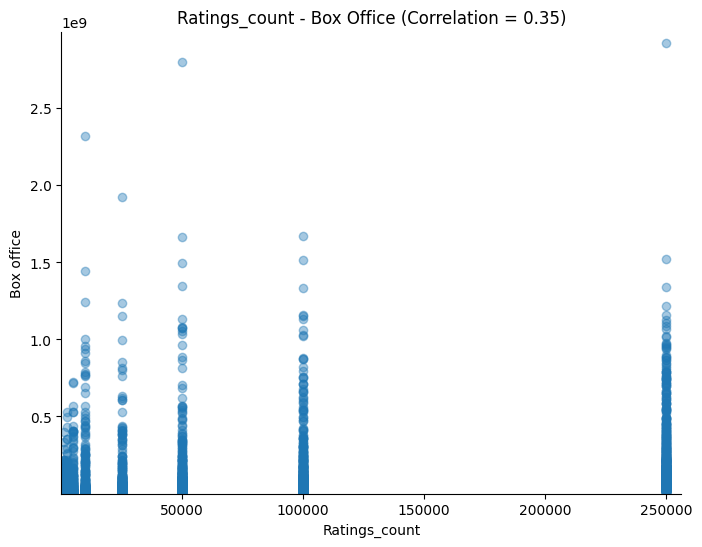

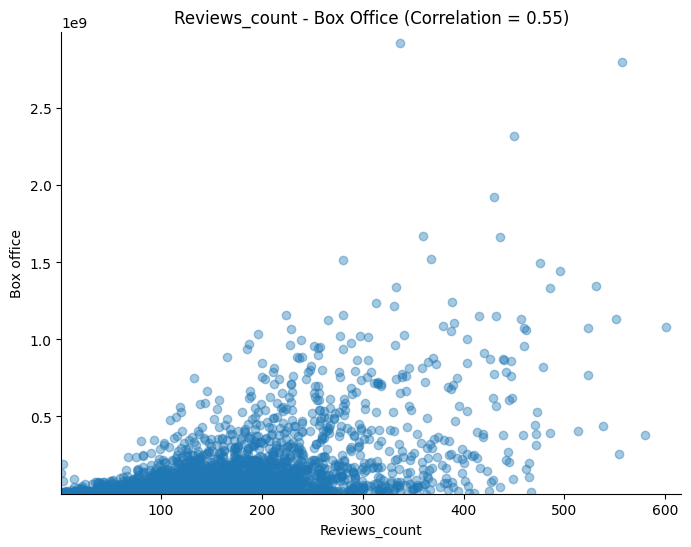

In [229]:
# Checking correlations with box office.

# Ratings.
plot_corr(train_data, 'Ratings_count')

# Reviews.
plot_corr(train_data, 'Reviews_count')

# Reviews' count appear to have correlation and Ratings' count appears to have little but once again let's remember
# that these scores aren't the final features because they aren't known before movie premiere. These features will 
# require data engineering and will be considered as average from x years of previous movies by director/actors.

In [230]:
# Checking ratios of missing values in ratings and reviews.
ratio_of_na(train_data, 'Ratings_count')
ratio_of_na(train_data, 'Reviews_count')

Ratio of missing values: 0.0498
Ratio of missing values: 0.0498


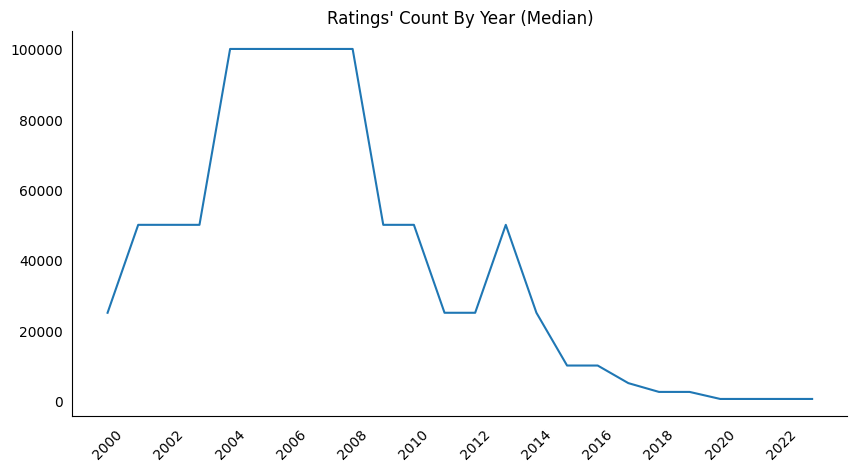

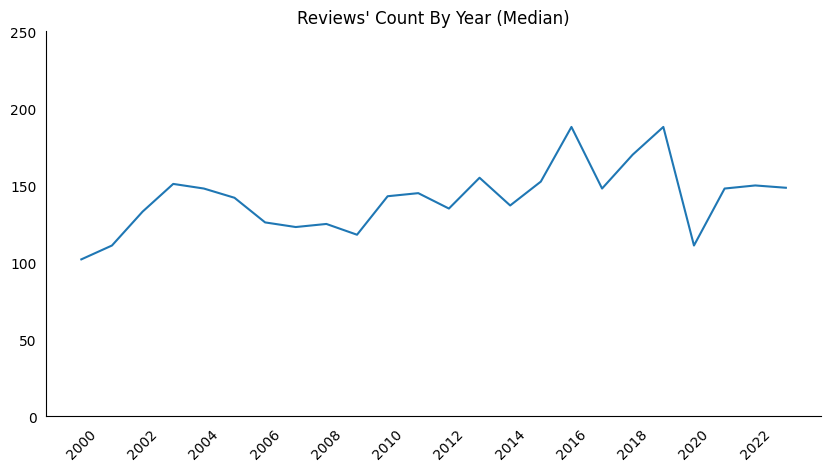

In [231]:
# Checking if time has an impact on ratings' and reviews' count.
simple_line_chart(train_data, 'Ratings_count', "Ratings' Count", 'median')
simple_line_chart(train_data, 'Reviews_count', "Reviews' Count", 'median', 0, 250)

# It appears to have a great impact on ratings' count.
# The reason could be rise and fall in popularity of rottentomatoes.com.
# More users equals more ratings. This is why I will include this while filling in missing values in ratings' count.

In [232]:
# Filling in missing values in 'Ratings' count' using median and grouping by year.
fill_with_median(train_data, 'Ratings_count', 'Year')

# Filling in missing values in 'Reviews' count' using median (without any grouping).
fill_with_median(train_data, 'Reviews_count')

Feature: 'Rating'

In [233]:
# Summary of descriptive statistics to check impact of Rating on box office.
train_data.groupby('Rating:')['Clean box office'].describe().sort_values(by='50%', ascending=False)

# As seen in high differences in distribution between some ratings, this column can be potentially valuable feature 
# with considerable explanatory power. Because the order by mean and the order by median are different. It will be
# better to use dummy encoding instead of ordinal encoding.

,count,mean,std,min,25%,50%,75%,max
Rating:,,,,,,,,
G,68.0,1.681906e+08,2.066443e+08,1100000.000,27025000.0,102650000.0,192925000.0,1.073000e+09
PG,471.0,1.736787e+08,2.407142e+08,32307.000,17100000.0,77200000.0,213000000.0,1.663000e+09
PG-13,1326.0,1.605359e+08,2.724844e+08,7502.846,17725000.0,58050000.0,173900000.0,2.923000e+09
R,1645.0,5.022828e+07,8.640179e+07,2132.000,2000000.0,15300000.0,62000000.0,1.079000e+09


In [234]:
# Checking ratio of missing values.
ratio_of_na(train_data, 'Rating:')

Ratio of missing values: 0.0902


In [235]:
# I will fill in missing values with the rating that appears the most times for specific studio.
# Because in general R category appears the most but for example it would be strange to fill in
# missing values for Disney with such high category.

def fill_in_ratings(df):
    # Finding most common ratings for every studio.
    try:
        most_common_ratings = df.groupby('Distributed by')['Rating:'].apply(lambda x: x.mode()[0])
    except KeyError:
        most_common_ratings = np.nan
    else:
        # Filling in missing values:
        for index, row in df.iterrows():
            if pd.isna(row['Rating:']):
                studio = row['Distributed by']
                df.at[index, 'Rating:'] = most_common_ratings[studio]

fill_in_ratings(train_data)

In [236]:
# Dummy encoding.
train_data = dummy_encoding(train_data, 'Rating:')

Feature: 'Genres'

In [237]:
# Summary of descriptive statistics to check impact of Genre on box office.
train_data.groupby('Genre_1')['Clean box office'].describe().sort_values(by='50%', ascending=False)

# As seen in high differences in distribution between some genres these columns can be potentially
# valuable features with considerable explanatory power.

,count,mean,std,min,25%,50%,75%,max
Genre_1,,,,,,,,
Kids & family,337.0,2.352012e+08,2.636861e+08,488232.0,50500000.0,141900000.0,342700000.0,1.663000e+09
Sci-fi,143.0,2.600799e+08,3.898121e+08,19996.0,30250000.0,122400000.0,350700000.0,2.923000e+09
Adventure,89.0,2.328775e+08,2.904054e+08,39027.0,43900000.0,120700000.0,335000000.0,1.671000e+09
Fantasy,70.0,2.786990e+08,3.493207e+08,48758.0,41700000.0,113800000.0,380800000.0,1.342000e+09
Action,385.0,2.382915e+08,3.380442e+08,618.0,22600000.0,93900000.0,331500000.0,2.799000e+09
War,33.0,1.193972e+08,1.553483e+08,90777.0,14500000.0,65900000.0,154800000.0,5.474000e+08
Musical,33.0,1.151988e+08,1.433741e+08,7671.0,4900000.0,54000000.0,185400000.0,4.470000e+08
Holiday,48.0,7.067735e+07,6.837323e+07,50292.0,12675000.0,49050000.0,107675000.0,2.599000e+08
Horror,264.0,6.688186e+07,8.722107e+07,4883.0,8500000.0,40500000.0,91587500.0,7.018000e+08


In [238]:
# Checking ratio of missing values in Genre_1 and _2.
ratio_of_na(train_data, 'Genre_1')
ratio_of_na(train_data, 'Genre_2')
ratio_of_na(train_data, 'Genre_3')

Ratio of missing values: 0.0505
Ratio of missing values: 0.2965
Ratio of missing values: 0.6822


In [239]:
# I decided to fill in missing values in Genre_1 with the genre of most similar movie.
def fill_in_genre(df):
    # Executing for every row with missing Genre_1.
    for index, row in df[df['Genre_1'].isnull()].iterrows():
        # Finding similar movie that has Genre_1 value.
        filtered_df = df[(df['Distributed by'] == row['Distributed by']) &
                         (df['Rating:'] == row['Rating:']) &
                         (df['Year'] == row['Year']) &
                         (df['Genre_1'].notnull())]

        if not filtered_df.empty:
            # Finding the closest box office result in the group of similar movies.
            similar_movie_index = (filtered_df['Clean box office'] - row['Clean box office']).abs().idxmin()
            closest_movie = filtered_df.loc[similar_movie_index, :]
            # Filling in missing value.
            df.at[index, 'Genre_1'] = closest_movie['Genre_1']

    # Removing rows if similar movie wasn't found.   
    df.dropna(subset=['Genre_1'], inplace=True)

    # Missing values in 'Genre_2' and 'Genre_3 will be filled in with 'Genre_1'.
    df.loc[df['Genre_2'].isna(), 'Genre_2'] = df.loc[df['Genre_2'].isna(), 'Genre_1']
    df.loc[df['Genre_3'].isna(), 'Genre_3'] = df.loc[df['Genre_3'].isna(), 'Genre_1']

fill_in_genre(train_data)

In [240]:
# Creating dummy features from 'Genre_1', 'Genre_2' and 'Genre_3'.
def dummy_genres(df, columns_to_drop=False):
    # Checking unique values - always from train_data to prevent data leakage if test_data has some different options.
    unique_genres = set(train_data['Genre_1'].unique()).union(set(train_data['Genre_2'].unique()).union(set(train_data['Genre_3'].unique())))

    # Creating columns.
    for genre in unique_genres:
        df[genre] = 0

    # Setting 1 in the corresponding columns.
    for index, row in df.iterrows():
        # Checking in Genre_1, _2 and _3.
        for i in range(1, 4):
            if pd.notna(row[f'Genre_{i}']):
                df.at[index, row[f'Genre_{i}']] = 1

    if columns_to_drop:
         df.drop(genre_columns_to_drop, axis=1, inplace=True)

dummy_genres(train_data)

# Creating list of genre columns that weren't used at least 30 times in train_data.
genre_columns_to_drop = []
for column in train_data.loc[:, 'R':].columns[1:]:
    if sum(train_data[column]) < 30:
        genre_columns_to_drop.append(column)

# Droping columns from the above list.
train_data.drop(genre_columns_to_drop, axis=1, inplace=True)

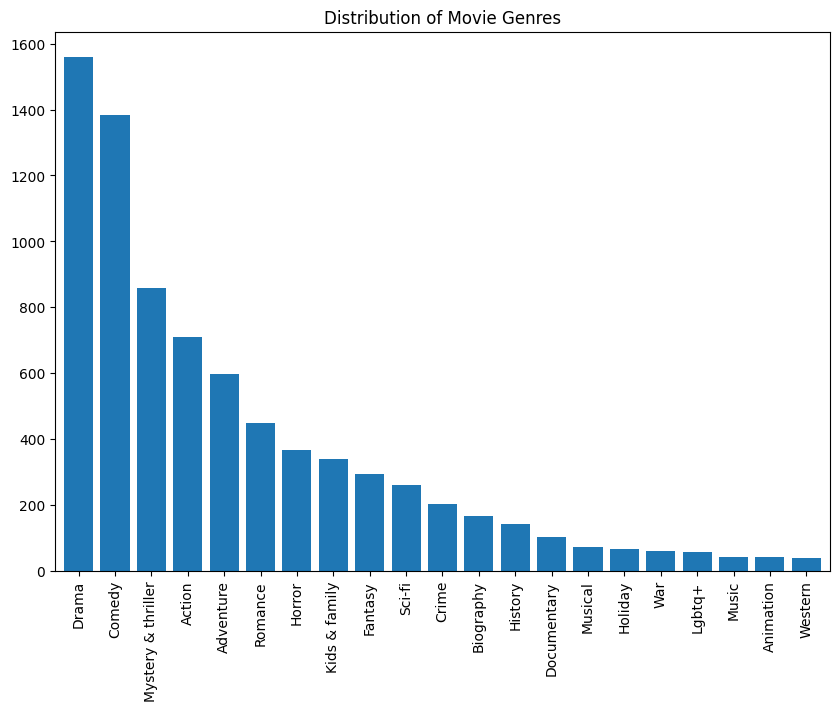

In [241]:
# Now let's also see distribution/count of movie genres among connected _1, _2 and _3.
genres_count = train_data.loc[:, train_data.loc[:, 'R':].columns[1:]].sum().sort_values(ascending=False)
genres_count.plot.bar(figsize=(10, 7), width=0.8)
plt.title('Distribution of Movie Genres')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.show()

# As we can see dramas and comedies are by far the most common.
# Very interesting is the 'Western' category on the last place. If we would go back about 50 years in the past they would probably dominate statistics.
# Fantasy and Sci-fi despite being one of the highest grossing categories isn't big in number. We can explain this by much higher costs of producing
# these movies (visible on the chart: 'Ratio of Movies With Budget Over $100m by Genre'). Highest budged means bigger risk. Also the year has only 12 
# months and the distributors try to avoid situation where 2 high budget movies are premiering in the same time.

# Worth noting: I didn't connected 'Kids & family' and 'Animation' categories because 'Animation' category mostly includes movies for adults.

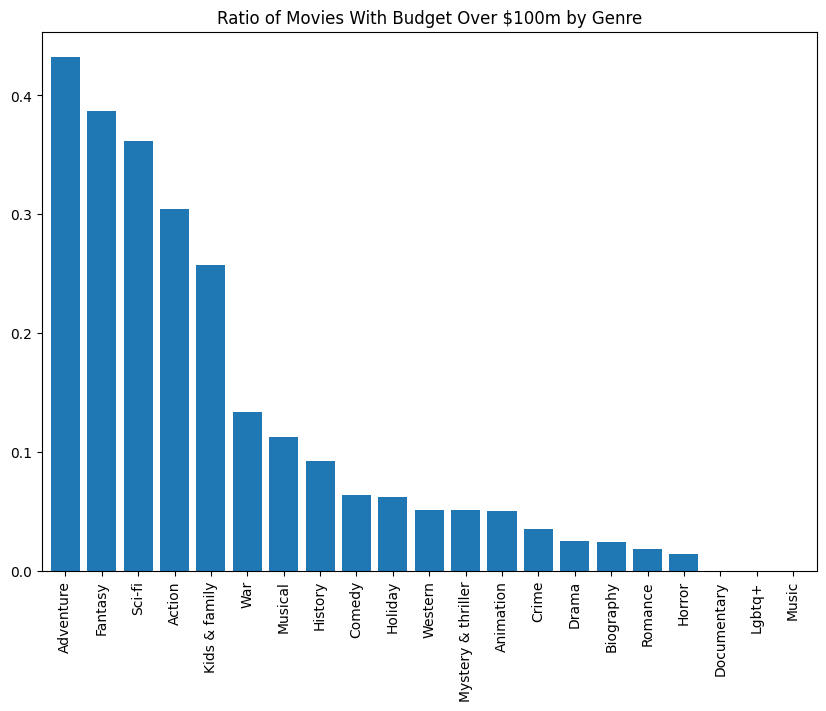

In [242]:
# Ratio of blockbusters movies by genre.

blockbusters_count = train_data.loc[train_data['Clean budget'] > 1e8, train_data.loc[:, 'R':].columns[1:]].sum()
blockbusters_ratio = blockbusters_count.divide(genres_count).sort_values(ascending=False)

blockbusters_ratio.plot.bar(figsize=(10, 7), width=0.8)
plt.title('Ratio of Movies With Budget Over $100m by Genre')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.show()

Features: 'Director' and 'Actors'

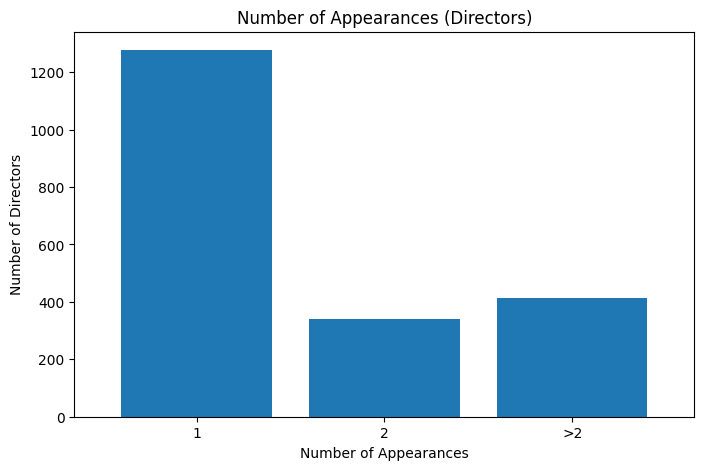

In [243]:
# Checking if there are enough 'more than 1' appearences of directors and actors to create
# for them new features in data engineering step based on their previous movies.

# Function that creates barplot that shows number of appearances.
def appearances_barplot(column, y_name):
    value_counts = column.value_counts()

    # I join all bars that have more than 2 appearances into one.
    counts_counts = value_counts.groupby(value_counts.clip(upper=3)).size()
    new_index = counts_counts.index[:-1].tolist() + ['>2']
    counts_counts.index = new_index

    # Creating barlot.
    counts_counts.plot.bar(figsize=(7, 5), width=0.8)
    plt.title(f'Number of Appearances ({y_name})')
    plt.xlabel('Number of Appearances')
    plt.ylabel(f'Number of {y_name}')
    plt.xticks(rotation=0)
    plt.show()

# Number of appearances for directors.
appearances_barplot(train_data['Director_1'], 'Directors')

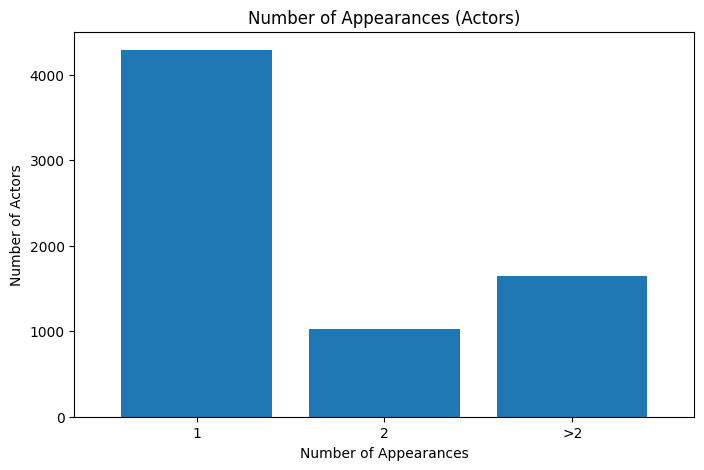

In [244]:
# Concatinating all actors' columns together:
actors = train_data.loc[:, 'Actor_1':'Actor_5'].stack()

# Number of appearances for actors.
appearances_barplot(actors, 'Actors')

In [245]:
# Both for actors and directors there are mostly single appearances but there is still enough multiple
# appearances among them to develop features in data engineering stage.
# Let's also remember that these bar plots doesn't include appearences from test set and additional set
# which will increase multiple appearances in data engineering.

Feature: 'Synopsis'

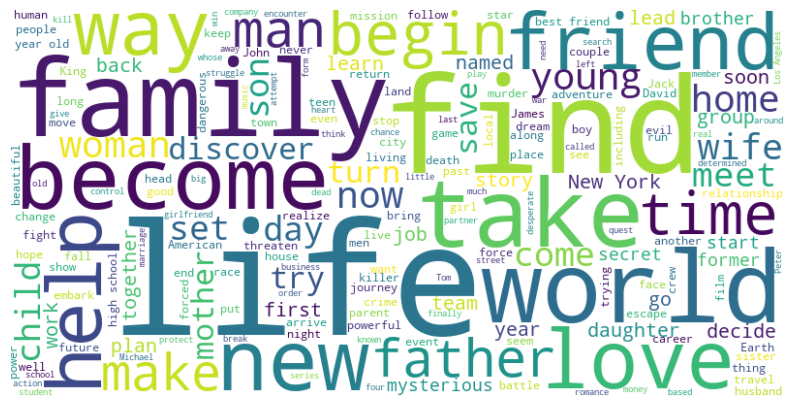

,Word,Frequency
0,life,1041
1,find,725
2,family,574
3,world,508
4,take,463
5,become,443
6,new,413
7,love,380
8,friend,364
9,way,356


In [246]:
# Creating cloud of tags from synopsis.

# Initializing lemmatizer and lemmatizing words.
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

text_processed = train_data['Synopsis'].dropna().apply(lemmatize_text)

# Adding additional words to be ignored.
additional_stopwords = ['will', 'must', 'may', 'though', 'one', 'two', 'three', '--', 's', 'ha', 'wa', 'u']
default_stopwords = set(WordCloud().stopwords)
all_stopwords = default_stopwords.union(additional_stopwords)

# Generating cloud of words.
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords)
wordcloud.generate(' '.join(text_processed))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Counting the frequency of words.
word_freq = wordcloud.process_text(' '.join(text_processed))
word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).reset_index(drop=True)
display(word_freq_df.head(15))

## Data engineering

From Feature: 'Synopsis'

In [247]:
# Checking counts of potential words that can influence box office results.
# 'sequel', 'prequel', 'continuation', 'installment', 'chapter', 'franchise' - those phrases indicate that the movie is part of 
# the bigger story/franchise and its brand can be already well-known to the audience.
word_freq_df.loc[word_freq_df['Word'].isin(['sequel', 'prequel', 'trilogy', 'continuation', 'chapter', 'installment', 'franchise']), :]

,Word,Frequency
1888,franchise,14
2987,sequel,9
3378,chapter,8
4009,trilogy,6
4923,installment,5
9853,continuation,2
10827,prequel,2


In [248]:
# Creating new feature based on 'Synopsis'.
def feature_from_synopsis(df, print_=False):
    df.fillna({'Synopsis': ''}, inplace=True)
    df['Franchise'] = 0
    df.loc[df['Synopsis'].str.contains('sequel|prequel|trilogy|continuation|chapter|installment|franchise', case=False), 'Franchise'] = 1
    if print_:
        print(df['Franchise'].value_counts())

feature_from_synopsis(train_data, True)

# As seen below, information about the movie being part of the franchise or part of the superhero genre shows too rarely
# in synopsis to use these features in ML model.
# This is why I did additional scraping from wikipedia and then developed those features from movie description instead of synopsis.

Franchise
0    3816
1      42
Name: count, dtype: int64


From Feature: 'Description'

In [249]:
def features_from_description(df, print_=False):
    # Extracting title of the previous movie in the franchise/series from description.
    df['Previous_movie_title'] = df['Description'].str.extract(r'sequel.*?href="/wiki/([^"]+)(?!.+and <i><a href="/wiki/)')

    # Extracting information whether the movie is a part of any franchise.
    df['Part_of_franchise'] = 0
    df.loc[df['Description'].str.contains('franchise|film series', case=False), 'Part_of_franchise'] = 1
    if print_:
        print(df['Part_of_franchise'].value_counts())

features_from_description(train_data, True)

Part_of_franchise
0    3427
1     431
Name: count, dtype: int64


Connecting datasets for chronological features

In [250]:
# For this step datasets needs to be concatenated back together to develop features based on chronology.
# First, the previous cleansing functions need to be executed on additional_data and test_data so the column names would match.
# I'm not looking at any of the results from those 2 sets so data leakage is avoided (they weren't used in data exploration
# and their missing values were filled in separately).

for i, df in enumerate([test_data, additional_data]):
    clean_money(df, 'Box office', 'Clean box office')
    clean_money(df, 'Budget', 'Clean budget')
    clean_runtime(df)
    clean_reviews_ratings(df)
    clean_age_rating(df)
    df = split_genres(df)
    df = split_actors(df)
    map_based_on(df)
    clean_language(df)
    clean_distributors(df)
    df = remove_rows_cols(df)
    df['Year'] = df['Main release date'].dt.year
    add_pandemic(df)
    df = dummy_encoding(df, 'Distributed by')
    df['Month'] = df['Main release date'].dt.month
    fill_with_median(df, 'Clean budget', 'Distributed by')
    fill_with_median(df, 'Ratings_score')
    fill_with_median(df, 'Reviews_score')
    fill_with_median(df, 'Ratings_count', 'Year')
    fill_with_median(df, 'Reviews_count')
    fill_in_ratings(df)
    df = dummy_encoding(df, 'Rating:')
    fill_in_genre(df)
    feature_from_synopsis(df)
    features_from_description(df)
    dummy_genres(df, genre_columns_to_drop)
    if i == 0:
        test_data = df
    else:
        additional_data = df

# Concatenating datasets.
full_data = pd.concat([additional_data, train_data, test_data])

# Sorting matches chronologically and changing index to tourney_date (necessary to rolling/expanding function).
full_data.sort_values(by=['Main release date', 'Title'], inplace=True)

C:\Users\jakub\AppData\Local\Temp\ipykernel_11256\4268197789.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  values[1] = values[1].fillna(1).replace({'million': 1e6, 'billion': 1e9})
C:\Users\jakub\AppData\Local\Temp\ipykernel_11256\4268197789.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  values[1] = values[1].fillna(1).replace({'million': 1e6, 'billion': 1e9})


New Features: Rating Director's and Actors' Popularity

In [251]:
# Creating features that will assess popularity of director and actors.
# It will be created in 3 columns as the cumulative: 'box office' and 'reviews count' of previous movies.
# I'm not using 'ratings count' because as it was seen on the chart it is very strongly affected by year
# and additionaly people tend to give ratings years after movie premiere when they saw the movie on TV or streaming.
# I opted for increasing cumulative sums/maxes instead of moving window (expanding instead of rolling) because people usually
# don't forget popular movies so appearance of an actor in a movie from 20 years in the past can still have impact on the
# actors popularity.

# For director's box office I decided to choose max because the most successful movie is the one that
# director is usually known for. I also tested sum but max yield better results.

# Shift(1) is used not to include current movie in the result which shouldn't be known during prediction.
full_data['Max_prev_reviews_count_director'] = full_data.groupby('Director_1')['Reviews_count'].transform(
    lambda group: group.shift(1).expanding().max())
full_data['Max_prev_box_office_director'] = full_data.groupby('Director_1')['Clean box office'].transform(
    lambda group: group.shift(1).expanding().max())

# For actors calcualtions are a bit more complicated because actors are included in 5 different columns.
# So first I need to change data into long format, make calculations and then connect results to main df.
# Additionaly I will give weights to actors' columns because leading role of the movie has to have bigger impact on the movie result.
# So appearing as Actor_1 will contribute the full box office earnings of the movie to the actor's overall popularity rating,
# appearing as Actor_2 will give him 0.8 of box office and so on.

def actors_impact(df, agg_column_name, new_column_name, ignore_kids_movies=False):
    # Converting to long format.
    actors_data = df.loc[:, ['Title', 'Main release date', 'Genre_1', 'Actor_1', 'Actor_2', 'Actor_3', 'Actor_4', 'Actor_5', agg_column_name]]
    actors_data_long = pd.melt(actors_data, id_vars=['Title', 'Main release date', 'Genre_1', agg_column_name], var_name='Actor_role',
                               value_name='Actor')
    actors_data_long = actors_data_long.sort_values(by=['Main release date', 'Title'])

    # Creating column with weights for actors.
    weights = {'Actor_1': 1.0, 'Actor_2': 0.8, 'Actor_3': 0.6, 'Actor_4': 0.4, 'Actor_5': 0.2}
    actors_data_long['Weight'] = actors_data_long['Actor_role'].map(weights)

    # If the main genre of the movie (Genre_1) is equal to 'Kids & family' then I give myself option to ignore these movies
    # while rating actors' popularity because most of these movies are animated movies so the actors aren't even present on the screen,
    # they're doing only voiceover and only in English speaking countries. So such movies shouldn't boost their popularity.
    # Adding to actors' popularity doesn't make sense for these movies.
    if ignore_kids_movies:
        actors_data_long.loc[actors_data_long['Genre_1'] == 'Kids & family', 'Weight'] = 0
    actors_data_long.drop('Genre_1', axis=1, inplace=True)

    # Product of weight and box office.
    actors_data_long[f'Weighted {agg_column_name}'] = actors_data_long[agg_column_name] * actors_data_long['Weight']

    # Calculating weighted increasing sum for each actor.
    actors_data_long[new_column_name] = actors_data_long.groupby('Actor')[f'Weighted {agg_column_name}'].transform(
        lambda x: x.shift(1).expanding().sum())

    # Adding all the actors together to form the result for each movie.
    actors_data_grouped = actors_data_long.groupby(['Title', 'Main release date'])[new_column_name].sum().reset_index()
    
    # Adding new column to the main dataframe.
    df = pd.merge(df, actors_data_grouped[['Title', 'Main release date', new_column_name]], on=['Title', 'Main release date'])
    return df

full_data = actors_impact(full_data, 'Clean box office', 'Prev_box_office_actors', True)
full_data = actors_impact(full_data, 'Reviews_count', 'Prev_reviews_count_actors', True)

New Features: Rating Director's Skill

In [252]:
# Creating features that will assess director's skill. I won't be made for actors because the director is the main 
# factor when it comes to the movie quality and the rest of creative decisions is dependant on him.

full_data['Avg_reviews_score_director'] = full_data.groupby('Director_1')['Reviews_score'].transform(
    lambda group: group.shift(1).expanding().mean())
full_data['Avg_ratings_score_director'] = full_data.groupby('Director_1')['Ratings_score'].transform(
    lambda group: group.shift(1).expanding().mean())

New feature: Main Genre's Box Office

In [253]:
# Despite having genres as dummy features I also add median of main genre's box office.
# It gives additional information because helps to distinguish main genre from the rest.
full_data['Median_main_genre_box_office'] = full_data.groupby('Genre_1')['Clean box office'].transform(
    lambda group: group.shift(1).expanding().median())

New Feature: Assessing Competition During Premiere

In [254]:
# Creating feature that will assess competition during the movie premiere.
# It will be the sum of budgets in the current week minus the budget of the current movie.
# I can use such feature because dates of premieres are set at least several months in advance
# and by that time, the approximate budgets are already known as well.

full_data['Week'] = full_data['Main release date'].dt.to_period('W')
full_data['Weekly_budget'] = full_data.groupby('Week')['Clean budget'].transform('sum') - full_data['Clean budget']

# The second option is ratio between the budget of the current movie and the sum of budgets in the current week.
full_data['Weekly_budget_ratio'] = full_data['Clean budget'] / full_data.groupby('Week')['Clean budget'].transform('sum')

New Feature: Box Office of the Previous Movie in the Franchise

In [255]:
# Creating a feature that will determine if the movie is a sequel to another movie, and if so, assigning
# the box office results of the previous movie.
full_data = pd.merge(full_data, full_data[['Title', 'Clean box office']], left_on='Previous_movie_title',
                     right_on='Title', how='left', suffixes=('', '_prev'))
full_data.rename(columns={'Clean box office_prev': 'Previous_movie_box_office'}, inplace=True)

Splitting datasets

In [256]:
# Splitting datasets again to prevent data leakage before exploratory analysis of new features.
# Additional data from years 1990-1999 won't be needed anymore.
# It was only needed to establish actors popularity and director's skill but won't be used in the learning process.
train_data = full_data.loc[full_data['Source'] == 'train_data', :]
test_data = full_data.loc[full_data['Source'] == 'test_data', :]

## Data exploration of new features

Features: Director's and Actors' Popularity

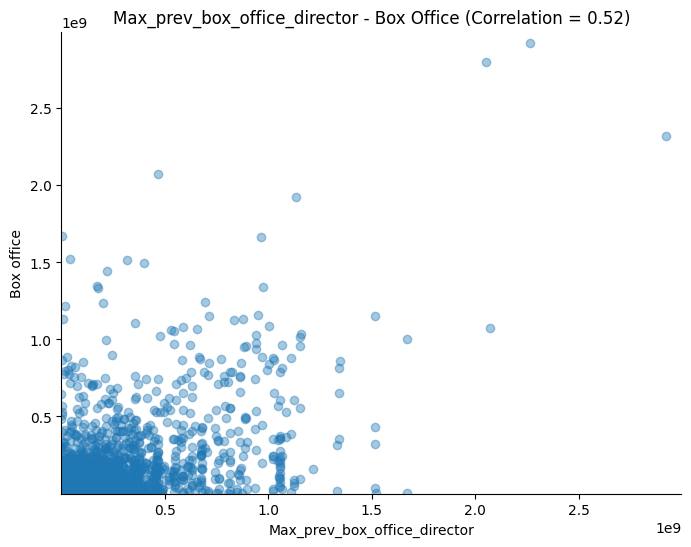

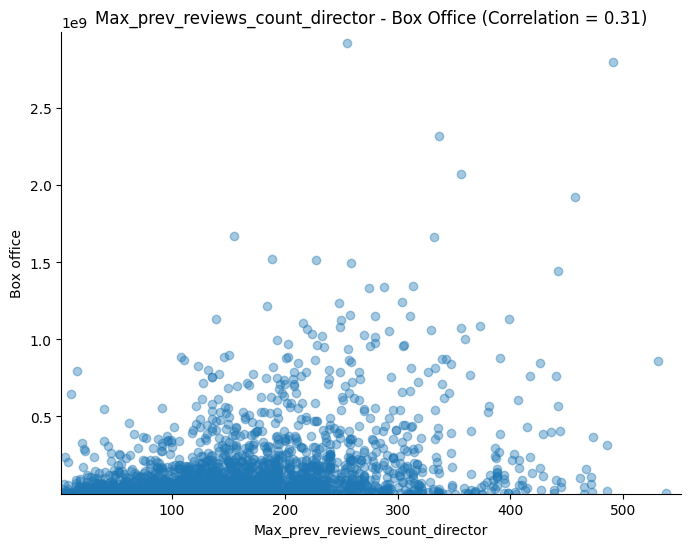

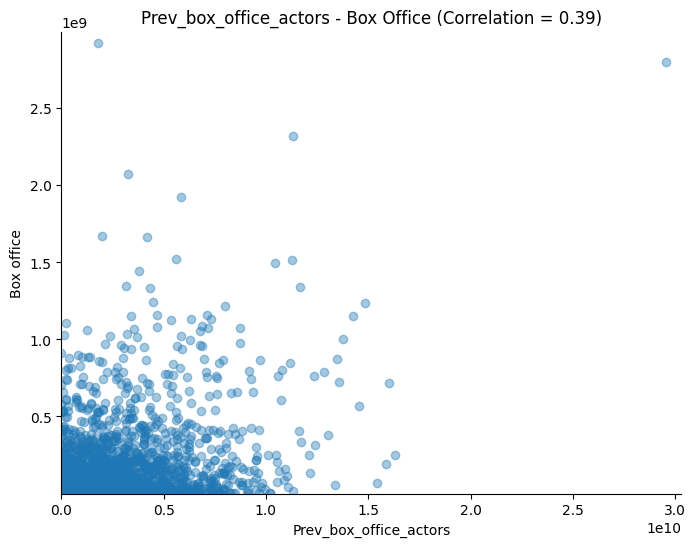

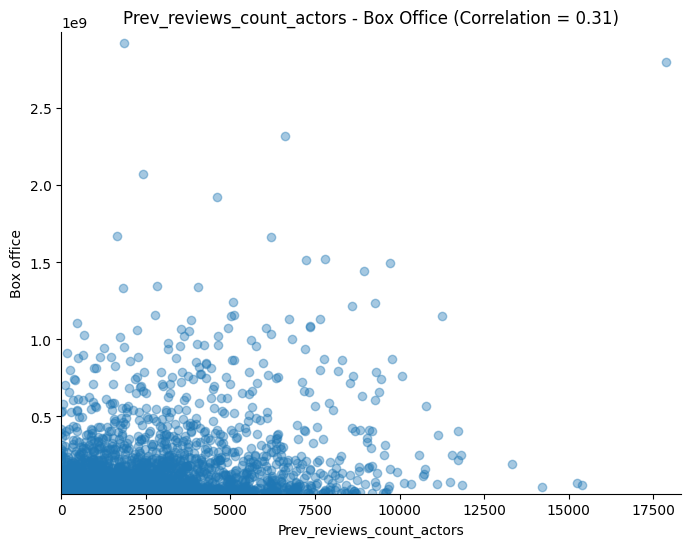

In [257]:
# Checking correlations with box office.
plot_corr(train_data, 'Max_prev_box_office_director')
plot_corr(train_data, 'Max_prev_reviews_count_director')
plot_corr(train_data, 'Prev_box_office_actors')
plot_corr(train_data, 'Prev_reviews_count_actors')

# Looking at the scatter plots and correlation, features based on previous box office seem to have much better
# explonatory power than features based on reviews' count.

Feature: Director's Skill

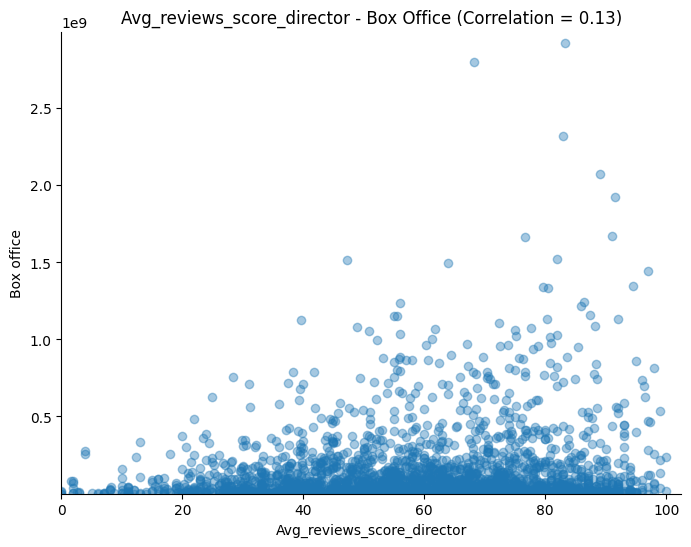

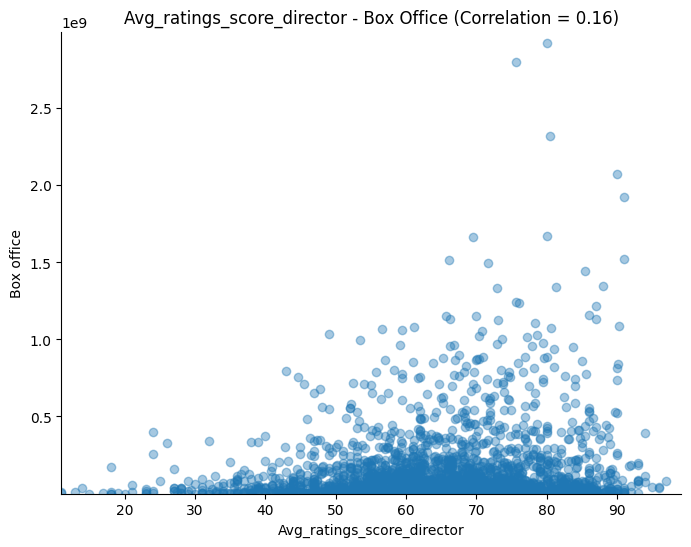

In [258]:
# Checking correlations with box office.
plot_corr(train_data, 'Avg_reviews_score_director')
plot_corr(train_data, 'Avg_ratings_score_director')

# From the following plots we can conclude that people rarely consider the quality of previous movies from given
# directors when deciding whether to go to the cinema.

Feature: Main Genre's Box Office

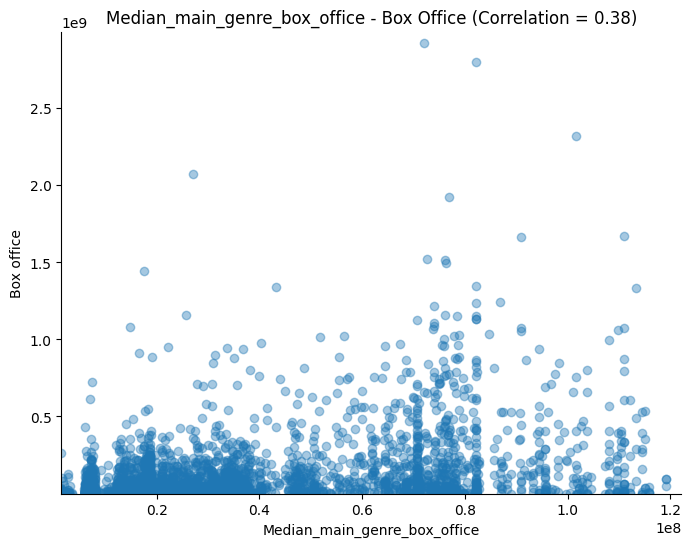

In [259]:
# Checking correlations with box office.
plot_corr(train_data, 'Median_main_genre_box_office')

# Box office of previous movies in genre appears to have some impact on current movie.

Feature: Weekly budget

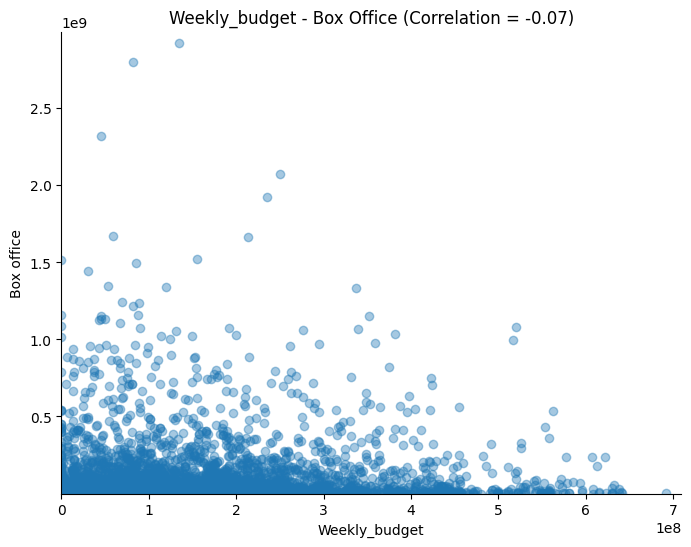

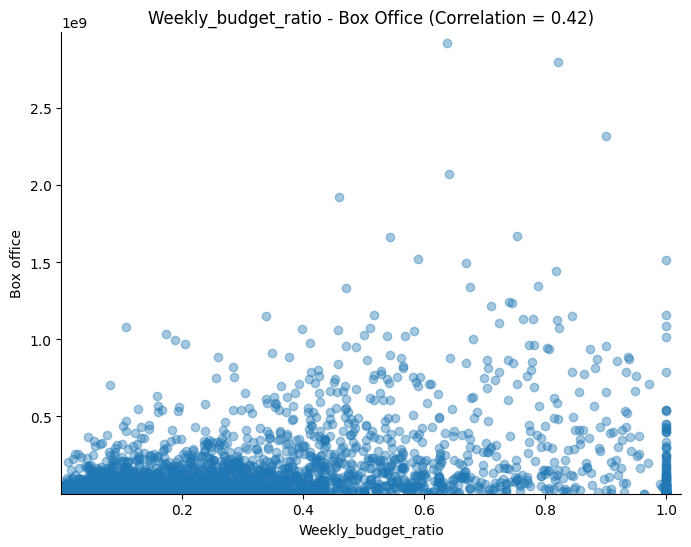

In [260]:
# Checking correlations with box office.
plot_corr(train_data, 'Weekly_budget')
plot_corr(train_data, 'Weekly_budget_ratio')

# From the following plots we can see that ratio feature seems to perform much better.

Feature: Previous movie's box office

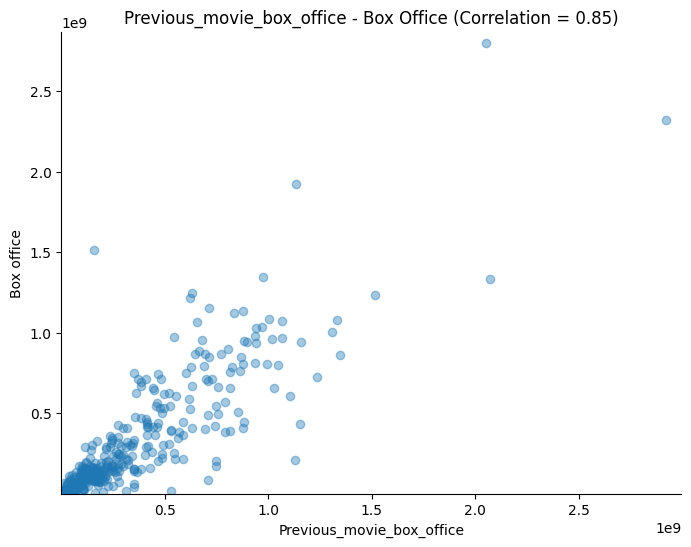

In [261]:
# Checking correlation with box office.
plot_corr(train_data, 'Previous_movie_box_office')

# It appears that results of previous movie in the franchise has great explanatory power for box office of the next movie.
# No wonder studios eagerly produce sequels to successful movies.

## Final steps

Removing unnecessarry columns

In [262]:
# Checking what columns are available after data engineering.
train_data.columns

Index(['Title', 'Distributed by', 'Running time', 'Based on',
       'Main release date', 'Director_1', 'Rating:', 'Reviews_score',
       'Ratings_score', 'Reviews_count', 'Ratings_count', 'Synopsis',
       'Clean box office', 'Clean budget', 'Genre_1', 'Genre_2', 'Genre_3',
       'Actor_1', 'Actor_2', 'Actor_3', 'Actor_4', 'Actor_5', 'English',
       'Description', 'Source', 'Year', 'Covid-19', '20th Century Fox',
       'Other studio', 'Paramount Pictures', 'Sony Pictures Releasing',
       'Streaming', 'Universal Pictures', 'Walt Disney Studios',
       'Warner Bros. Pictures', 'Month', 'G', 'PG', 'PG-13', 'R', 'Franchise',
       'Previous_movie_title', 'Part_of_franchise', 'Sci-fi', 'Biography',
       'Documentary', 'Mystery & thriller', 'Drama', 'Holiday', 'Western',
       'Horror', 'Fantasy', 'Action', 'Kids & family', 'Lgbtq+', 'War',
       'Crime', 'Comedy', 'History', 'Music', 'Romance', 'Adventure',
       'Animation', 'Musical', 'Lionsgate', 'Max_prev_reviews_count_d

In [263]:
# Removing unnecessary columns.
unnecessary_columns = ['Title', 'Distributed by', 'Main release date', 'Director_1', 'Rating:', 'Reviews_score', 'Ratings_score',
                    'Reviews_count', 'Ratings_count', 'Synopsis', 'Genre_1', 'Genre_2', 'Genre_3', 'Actor_1', 'Actor_2', 'Actor_3',
                    'Actor_4', 'Actor_5', 'Source', 'Prev_reviews_count_actors','Week', 'Weekly_budget', 'Max_prev_reviews_count_director',
                    'Avg_reviews_score_director', 'Franchise', 'Previous_movie_title', 'Title_prev', 'Description']

train_data = train_data.drop(unnecessary_columns, axis=1)
test_data = test_data.drop(unnecessary_columns, axis=1)

Filling in missing values

In [264]:
# Filling in 'Max_prev_box_office_director'/'Previous_movie_box_office' with 0 and 'Avg_ratings_score_director' with average.
for df in [train_data, test_data]:
    df.loc[df['Max_prev_box_office_director'].isnull(), 'Max_prev_box_office_director'] = 0
    df.loc[df['Previous_movie_box_office'].isnull(), 'Previous_movie_box_office'] = 0
    df.loc[df['Avg_ratings_score_director'].isnull(), 'Avg_ratings_score_director'] = df['Avg_ratings_score_director'].mean()

Checking multicollinearity

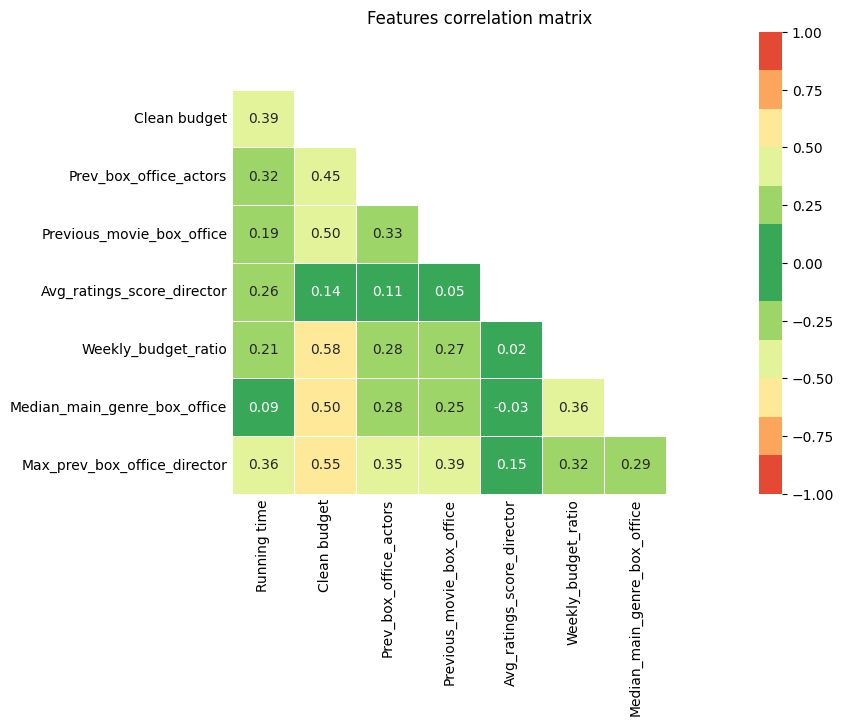

In [265]:
# Creating a correlation matrix for selected features.

# I removed 'Prev_reviews_count_actors' because it had very high correlation with 'Prev_box_office_actors' (0.92).
# I removed ''Max_prev_reviews_count_director'' because it had quite high correlation with 'Max_prev_box_office_director' (0.67).
# I removed 'Avg_reviews_score_director' because it had quite high correlation with 'Avg_ratings_score_director' (0.67).
# And both features had very small correlation with our target so there's no point in keeping them both in the model.
correlation_matrix = train_data[['Running time', 'Clean budget', 'Prev_box_office_actors',
                                'Previous_movie_box_office', 'Avg_ratings_score_director', 'Weekly_budget_ratio', 'Median_main_genre_box_office',
                                'Max_prev_box_office_director']].corr()

# Creating a mask to hide the higher triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
mypal = sns.color_palette('RdYlGn') + sns.color_palette('RdYlGn_r')
sns.heatmap(correlation_matrix, annot=True, cmap=mypal, fmt=".2f", linewidths=0.5, mask=mask, vmin=-1, vmax=1)

# Hiding the first label on the Y axis and the last label on the X axis
plt.gca().get_yticklabels()[0].set_visible(False)
plt.gca().get_xticklabels()[-1].set_visible(False)

plt.tick_params(axis='both', which='both', length=0)
plt.title('Features correlation matrix')
plt.show()

Saving clean datasets to file

In [266]:
train_data.to_csv('../data/03_processed_data/clean_train_data.csv', index=False)
test_data.to_csv('../data/03_processed_data/clean_test_data.csv', index=False)